In [307]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [308]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [309]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [310]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [311]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [312]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)


Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [313]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [316]:
era5_txx = xr.open_dataset('%s/txx/era5_txx.nc'%dirHeatData)
era5_txx.load()
era5_txx['txx'] -= 273.15

era5_tx_mean = xr.open_dataset('%s/txx/era5_t_mean.nc'%dirHeatData)
era5_tx_mean.load()
era5_tx_mean['t_mean'] -= 273.15

In [318]:
era5_txx

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 72)
Coordinates:
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 ... 2021-12-31
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    txx        (time, latitude, longitude) float32 2.252 2.252 ... -17.61 -17.61

In [265]:
# for y, year in enumerate(range(1981, 2020+1)):
#     os.rename('%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d.dat'%(dirHeatData, year), '%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d_%d.dat'%(dirHeatData, 95, year))

In [266]:
%%time

rebuild = False
ca_year = 1995

if rebuild:# not os.path.isfile('maize_hw_%d_regrid.dat'%ca_year) and not rebuild:
    crop_ha_lat = np.linspace(90, -90, 2160)
    crop_ha_lon = np.linspace(0, 360, 4320)

    print('processing maize...')
    maize_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Maize/Maize_%d_Area.tif'%(dirAgData, ca_year))
    maize_ha = maize_ha.read(1)
    maize_ha[abs(maize_ha) > 10] = np.nan
    maize_ha = np.roll(maize_ha, -int(maize_ha.shape[1]/2), axis=1)
    
    regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, lat.size)),
                             'lon': (['lon'], np.linspace(0, 360, lon.size)),})

    regridder = xe.Regridder(xr.DataArray(data=maize_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    maize_ha_regrid = regridder(maize_ha)
    
    with open('maize_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(maize_ha_regrid, f)
        
    print('processing soy...')
    soy_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Soybean/Soybean_%d_Area.tif'%(dirAgData, ca_year))
    soy_ha = soy_ha.read(1)
    soy_ha[abs(soy_ha) > 10] = np.nan
    soy_ha = np.roll(soy_ha, -int(soy_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=soy_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    soy_ha_regrid = regridder(soy_ha)
    
    with open('soy_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(soy_ha_regrid, f)
      
    
    print('processing wheat...')
    wheat_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Wheat/Wheat_%d_Area.tif'%(dirAgData, ca_year))
    wheat_ha = wheat_ha.read(1)
    wheat_ha[abs(wheat_ha) > 10] = np.nan
    wheat_ha = np.roll(wheat_ha, -int(wheat_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=wheat_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    wheat_ha_regrid = regridder(wheat_ha)
    
    with open('wheat_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(wheat_ha_regrid, f)
    
    
    print('processing rice...')
    rice_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Rice/Rice_%d_Area.tif'%(dirAgData, ca_year))
    rice_ha = rice_ha.read(1)
    rice_ha[abs(rice_ha) > 10] = np.nan
    rice_ha = np.roll(rice_ha, -int(rice_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=rice_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    rice_ha_regrid = regridder(rice_ha)
    
    with open('rice_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(rice_ha_regrid, f)
else:
    with open('maize_hw_%d_regrid.dat'%1995, 'rb') as f:
        maize_ha_regrid_1995 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2000, 'rb') as f:
        maize_ha_regrid_2000 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2005, 'rb') as f:
        maize_ha_regrid_2005 = pickle.load(f)
        
        
    with open('soy_hw_%d_regrid.dat'%1995, 'rb') as f:
        soy_ha_regrid_1995 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2000, 'rb') as f:
        soy_ha_regrid_2000 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2005, 'rb') as f:
        soy_ha_regrid_2005 = pickle.load(f)
        
    
    with open('wheat_hw_%d_regrid.dat'%1995, 'rb') as f:
        wheat_ha_regrid_1995 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2000, 'rb') as f:
        wheat_ha_regrid_2000 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2005, 'rb') as f:
        wheat_ha_regrid_2005 = pickle.load(f)

        
#     crop_ha_regrid = maize_ha_regrid + soy_ha_regrid# + wheat_ha_regrid# + rice_ha_regrid
#     crop_ha_regrid *= 100
#     crop_ha_regrid[crop_ha_regrid>100] = 100

CPU times: user 16 ms, sys: 40.3 ms, total: 56.4 ms
Wall time: 1.68 s


In [267]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_irr = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear', reuse_weights=True)

irrigationData_regrid = regridder_irr(irrigationData)
irrigationData_regrid_1d = irrigationData_regrid.reshape([irrigationData_regrid.size,1])

Reuse existing file: bilinear_2160x4320_721x1440.nc


In [268]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [269]:
ds_grow_r_t_et_total_evap_61_81 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1981.nc')
ds_grow_r_t_et_total_evap_61_81.load()

ds_grow_r_t_et_total_evap_71_91 = xr.open_dataset('r_t_et_era5_total_evaporation_1971_1991.nc')
ds_grow_r_t_et_total_evap_71_91.load()

ds_grow_r_t_et_total_evap_81_01 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001.nc')
ds_grow_r_t_et_total_evap_81_01.load()

ds_grow_r_t_et_total_evap_91_11 = xr.open_dataset('r_t_et_era5_total_evaporation_1991_2011.nc')
ds_grow_r_t_et_total_evap_91_11.load()

ds_grow_r_t_et_total_evap_01_21 = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021.nc')
ds_grow_r_t_et_total_evap_01_21.load()


ds_grow_r_t_et = xr.open_dataset('r_t_et_era5_total_evaporation_1961_2021.nc')
ds_grow_r_t_et.load()


<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    r_t_et   (lat, lon) float64 nan nan nan nan ... -0.1991 -0.1991 -0.1991

In [270]:
yearRange = np.arange(1981, 2020+1)

In [271]:
tx_during_tw_cmip6 = xr.Dataset()
tw_during_tx_cmip6 = xr.Dataset()

percentiles = np.array([50, 80, 90, 95, 96, 97, 98, 99])

tx_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tx_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

et_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
et_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

huss_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
huss_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

sm_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
sm_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

for y_ind, y in enumerate(yearRange):
    print(y)
    for p in range(percentiles.size):
        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tx[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tw[p, y_ind, :, :] = pickle.load(f)

        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tw[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tx[p, y_ind, :, :] = pickle.load(f)
            
        if os.path.isfile('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                et_during_tx[p, y_ind, :, :] = pickle.load(f)
                
        if os.path.isfile('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                sm_during_tx[p, y_ind, :, :] = pickle.load(f)
        
       
    with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_95_%d.dat'%(dirHeatData, y), 'rb') as f:
        et_during_tw[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tx[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tw[y_ind, :, :] = pickle.load(f)
        
        


1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [272]:
tx_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tx_diff_from_tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_diff_from_tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_diff_from_tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_diff_from_tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

et_during_tw_trend = np.full([lat.size, lon.size], np.nan)
et_during_tw_pval = np.full([lat.size, lon.size], np.nan)

et_during_tx_trend = np.full([lat.size, lon.size], np.nan)
et_during_tx_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tw_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tw_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tx_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tx_pval = np.full([lat.size, lon.size], np.nan)

with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_pval = pickle.load(f)
    

In [273]:
r_t_et_cmip6_1981_2000 = xr.Dataset()
r_t_et_cmip6_2000_2015 = xr.Dataset()
for m, model in enumerate(cmip6_models):
    
    
    
    if os.path.isfile('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_1981_2000_fixed_sh.nc'%(model)):
        print('loading %s'%model)
        ds_r_t_et_1981_2000 = xr.open_dataset('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_1981_2000_fixed_sh.nc'%(model))
    
        if m == 0:
            r_t_et_cmip6_1981_2000 = ds_r_t_et_1981_2000
        else:
            r_t_et_cmip6_1981_2000 = xr.concat([r_t_et_cmip6_1981_2000, ds_r_t_et_1981_2000], dim='model')
            
    if os.path.isfile('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_2000_2015_fixed_sh.nc'%(model)):
        print('loading %s'%model)
        ds_r_t_et_2000_2015 = xr.open_dataset('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_2000_2015_fixed_sh.nc'%(model))
    
        if m == 0:
            r_t_et_cmip6_2000_2015 = ds_r_t_et_2000_2015
        else:
            r_t_et_cmip6_2000_2015 = xr.concat([r_t_et_cmip6_2000_2015, ds_r_t_et_2000_2015], dim='model')


loading bcc-csm2-mr
loading bcc-csm2-mr
loading canesm5
loading canesm5
loading kace-1-0-g
loading kace-1-0-g
loading ipsl-cm6a-lr
loading ipsl-cm6a-lr
loading miroc6
loading miroc6


In [274]:
# compare era5 r(t, et) to cmip in 1981 - 2001

cmip6_era5_r_t_et_anom_1981_2000 = np.full([r_t_et_cmip6_1981_2000.r_t_et.lat.size, r_t_et_cmip6_1981_2000.r_t_et.lon.size, r_t_et_cmip6_1981_2000.r_t_et.model.size], np.nan)
cmip6_era5_r_t_et_anom_2000_2015 = np.full([r_t_et_cmip6_2000_2015.r_t_et.lat.size, r_t_et_cmip6_2000_2015.r_t_et.lon.size, r_t_et_cmip6_2000_2015.r_t_et.model.size], np.nan)

newLat = np.arange(-90, 90, 1.5)
newLon = np.arange(0, 360, 1.5)

# regrid era5 data to cmip6 res
regridMesh = xr.Dataset({'lat': (['lat'], newLat),
                         'lon': (['lon'], newLon),})

regridder = xe.Regridder(ds_grow_r_t_et_total_evap_81_01, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
ds_grow_r_t_et_total_evap_81_01_regrid = regridder(ds_grow_r_t_et_total_evap_81_01)

regridder = xe.Regridder(ds_grow_r_t_et_total_evap_01_21, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
ds_grow_r_t_et_total_evap_01_21_regrid = regridder(ds_grow_r_t_et_total_evap_01_21)

for m in range(r_t_et_cmip6_1981_2000.r_t_et.model.size):
    cmip6_era5_r_t_et_anom_1981_2000[:,:,m] = r_t_et_cmip6_1981_2000.r_t_et.values[m,:,:] - ds_grow_r_t_et_total_evap_81_01_regrid.r_t_et.values
    cmip6_era5_r_t_et_anom_2000_2015[:,:,m] = r_t_et_cmip6_2000_2015.r_t_et.values[m,:,:] - ds_grow_r_t_et_total_evap_01_21_regrid.r_t_et.values

Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
using dimensions ('lat', 'lon') from data variable r_t_et as the horizontal dimensions for this dataset.
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
using dimensions ('lat', 'lon') from data variable r_t_et as the horizontal dimensions for this dataset.


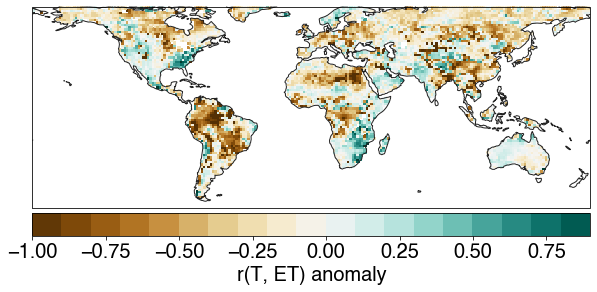

In [275]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_era5_r_t_et_anom_1981_2000[:,:,:], axis=2)
# data = np.nanmean(cmip6_era5_r_t_et_anom_2000_2015[:,:,:], axis=2)

# data = np.nanmean(r_t_et_cmip6_2000_2015.r_t_et.values-r_t_et_cmip6_1981_2000.r_t_et.values,axis=0)

c = plt.pcolormesh(newLon, newLat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET) anomaly', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [276]:
# for m, model in enumerate(cmip6_models):
#     print('loading %s'%model)
    
#     tx_during_tw_cur_model = xr.Dataset()
#     tw_during_tx_cur_model = xr.Dataset()
    
#     for y_ind, y in enumerate(yearRange):
#         ds_tw_on_tx = xr.open_dataset('%s/heat-wave-days/tw-on-tx/cmip6/%s/cmip6_tw_on_tx_%d_%s.nc'%(dirHeatData, model, y, model))
#         ds_tx_on_tw = xr.open_dataset('%s/heat-wave-days/tx-on-tw/cmip6/%s/cmip6_tx_on_tw_%d_%s.nc'%(dirHeatData, model, y, model))
    
#         if y_ind == 0:
#             tx_during_tw_cur_model = ds_tx_on_tw
#             tw_during_tx_cur_model = ds_tw_on_tx
#         else:
#             tx_during_tw_cur_model = xr.concat([tx_during_tw_cur_model, ds_tx_on_tw], dim='time')
#             tw_during_tx_cur_model = xr.concat([tw_during_tx_cur_model, ds_tw_on_tx], dim='time')
    
#     if m == 0:
#         tx_during_tw_cmip6 = tx_during_tw_cur_model
#         tw_during_tx_cmip6 = tw_during_tx_cur_model
#     else:
#         tx_during_tw_cmip6 = xr.concat([tx_during_tw_cmip6, tx_during_tw_cur_model], dim='model')
#         tw_during_tx_cmip6 = xr.concat([tw_during_tx_cmip6, tw_during_tx_cur_model], dim='model')

In [277]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = 0
# v2 = 1.01
# vstep = .1
# vlabelstep = .25

# midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
# cmap = plt.cm.get_cmap('Reds')

# # data = ds_grow_r_t_et.r_t_et.values
# data = np.nanmean(tx_during_tw, axis=0)
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Tx during Tw (Percentile)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [278]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = -.01
# v2 = .011
# vstep = .001
# vlabelstep = .005

# midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
# cmap = plt.cm.get_cmap('bwr')

# # data = ds_grow_r_t_et.r_t_et.values
# data = tx_during_tx_trend * 10
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in Tx during Tx (Percentile/decade)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [279]:
maize_chg = maize_ha_regrid_2005-maize_ha_regrid_1995

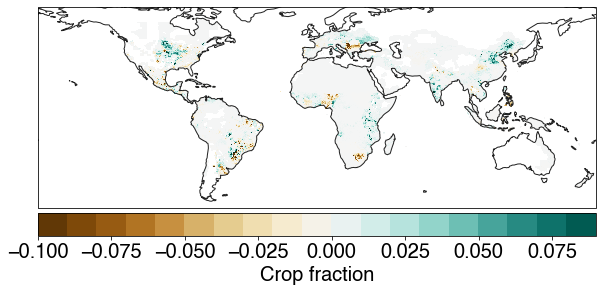

In [280]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .1
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = maize_chg

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

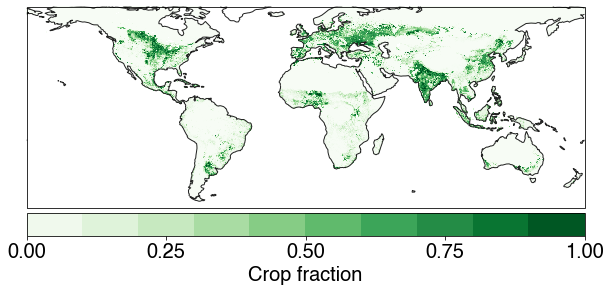

In [281]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [282]:
crop_ha_regrid.shape

(721, 1440)

In [283]:
rebuild = True

if rebuild:
    
    
    crop_ha_regrid_shift = crop_ha_regrid.copy()
    crop_ha_regrid_below = crop_ha_regrid.copy()
    crop_ha_regrid_above = crop_ha_regrid.copy()

    maize_chg_shift = maize_chg.copy()
    maize_chg_below = maize_chg.copy()
    maize_chg_above = maize_chg.copy()


    for x in range(crop_ha_regrid.shape[0]):
        if x%10 == 0: print(x)
        for y in range(crop_ha_regrid.shape[1]):
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_shift[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0):
                crop_ha_regrid_below[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_above[x,y]=np.nan


                
    with open('crop_rt_below_1981-2000_2001-2020.dat', 'wb') as f:
        pickle.dump(crop_ha_regrid_below, f)
    with open('crop_rt_above_1981-2000_2001-2020.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_above, f)
    with open('crop_rt_shift_1981-2000_2001-2020.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_shift, f)
else:
    with open('crop_rt_below.dat', 'rb') as f:
        crop_ha_regrid_below = pickle.load(f)
    with open('crop_rt_above.dat', 'rb') as f:
        crop_ha_regrid_above = pickle.dump(f)
    with open('crop_rt_shift.dat', 'rb') as f:
        crop_ha_regrid_shift = pickle.dump(f)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720


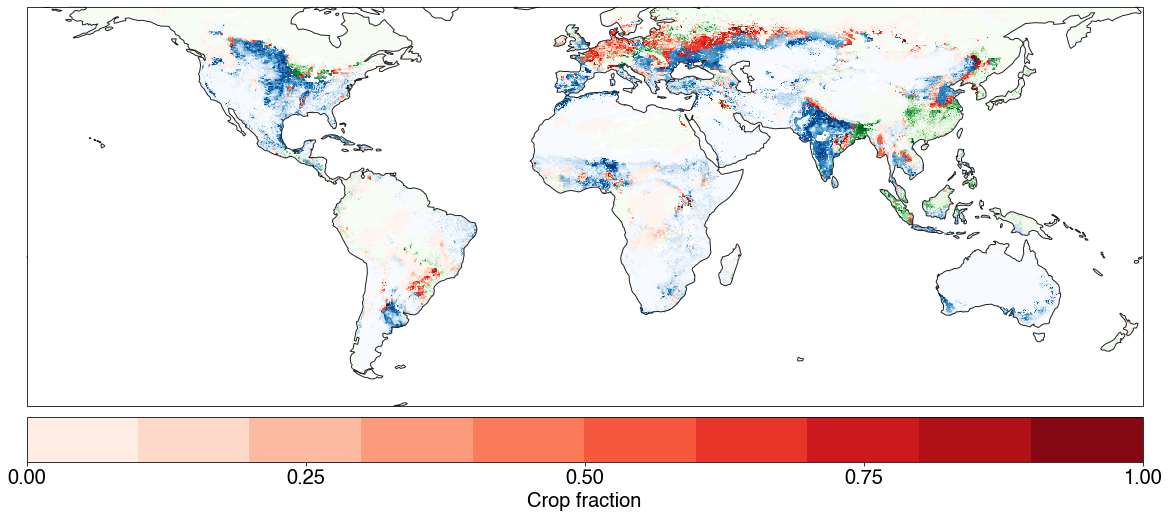

In [284]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

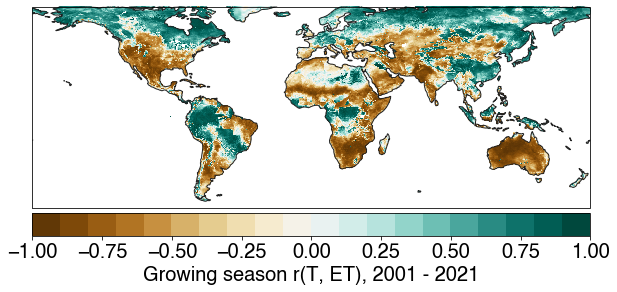

In [285]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_81_01.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET), 2001 - 2021', fontsize=20)

# plt.savefig('growing-season-r-t-et-map-01-21.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

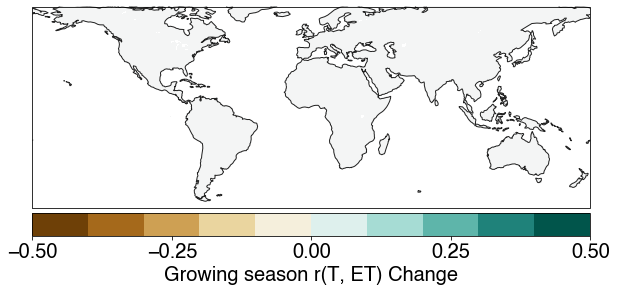

In [286]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.5
v2 = .51
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_81_01.r_t_et.values-ds_grow_r_t_et_total_evap_81_01.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET) Change', fontsize=20)

plt.savefig('growing-season-r-t-et-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [287]:
lat_global_ind = np.arange(lat.size)
lat_global_no_ice_ind = np.where((lat>=-65) & (lat<=60))[0]
lat_nontropics_ind = np.where(((lat>=30) | (lat<=-30)) & (lat<=65) & (lat>=-65))[0]
lat_nh_ind = np.where((lat>=30) & (lat<=65))[0]
lat_tropics_ind = np.where((lat<30) & (lat>-30))[0]
lat_sh_ind = np.where((lat <= -30) & (lat >= -60))[0]


In [288]:
lat_ind_sel = lat_nontropics_ind

time_split = 20

# determine array size
num_elements = np.nanmean(tx_during_tw[0,:,:,:], axis=0)
num_elements = num_elements[lat_ind_sel,:].size

tx_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)

tx_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

tw_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

et_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

sm_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

tw_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tw_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tw_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

for p in range(percentiles.size):
    
    t = np.nanmean(tx_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tw_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(et_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    et_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(sm_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    sm_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(tw_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_2_1d[p, :] = t.reshape([t.size])

In [289]:

et_during_tw_sel = np.nanmean(et_during_tw, axis=0)
et_during_tw_sel = et_during_tw_sel[lat_ind_sel,:]
et_during_tw_sel_1d = et_during_tw_sel.reshape([et_during_tw_sel.size, 1])

# et_during_tx_sel = np.nanmean(et_during_tx, axis=0)
# et_during_tx_sel = et_during_tx_sel[lat_ind_sel,:]
# et_during_tx_sel_1d = et_during_tx_sel.reshape([et_during_tx_sel.size, 1])

# et_during_tx_1_sel = np.nanmean(et_during_tx[0:20,:,:], axis=0)
# et_during_tx_1_sel = et_during_tx_1_sel[lat_ind_sel,:]
# et_during_tx_1_sel_1d = et_during_tx_1_sel.reshape([et_during_tx_1_sel.size, 1])

# et_during_tx_2_sel = np.nanmean(et_during_tx[20:,:,:], axis=0)
# et_during_tx_2_sel = et_during_tx_2_sel[lat_ind_sel,:]
# et_during_tx_2_sel_1d = et_during_tx_2_sel.reshape([et_during_tx_2_sel.size, 1])

# huss_during_tx_sel = np.nanmean(huss_during_tx, axis=0)
# huss_during_tx_sel = huss_during_tx_sel[lat_ind_sel,:]
# huss_during_tx_sel_1d = huss_during_tx_sel.reshape([huss_during_tx_sel.size, 1])

huss_during_tx_1_sel = np.nanmean(huss_during_tx[0:time_split,:,:], axis=0)
huss_during_tx_1_sel = huss_during_tx_1_sel[lat_ind_sel,:]
huss_during_tx_1_sel_1d = huss_during_tx_1_sel.reshape([huss_during_tx_1_sel.size, 1])

huss_during_tx_2_sel = np.nanmean(huss_during_tx[time_split:,:,:], axis=0)
huss_during_tx_2_sel = huss_during_tx_2_sel[lat_ind_sel,:]
huss_during_tx_2_sel_1d = huss_during_tx_2_sel.reshape([huss_during_tx_2_sel.size, 1])

# sm_during_tx_1_sel = np.nanmean(sm_during_tx[0:20,:,:], axis=0)
# sm_during_tx_1_sel = sm_during_tx_1_sel[lat_ind_sel,:]
# sm_during_tx_1_sel_1d = sm_during_tx_1_sel.reshape([sm_during_tx_1_sel.size, 1])

# sm_during_tx_2_sel = np.nanmean(sm_during_tx[20:,:,:], axis=0)
# sm_during_tx_2_sel = sm_during_tx_2_sel[lat_ind_sel,:]
# sm_during_tx_2_sel_1d = sm_during_tx_2_sel.reshape([sm_during_tx_2_sel.size, 1])

huss_during_tw_sel = np.nanmean(huss_during_tw, axis=0)
huss_during_tw_sel = huss_during_tw_sel[lat_ind_sel,:]
huss_during_tw_sel_1d = huss_during_tw_sel.reshape([huss_during_tw_sel.size, 1])

et_during_tw_trend_sel = et_during_tw_trend[lat_ind_sel, :]*10
et_during_tw_trend_zonal_sel = (et_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tw_trend[lat_ind_sel, :],  axis=1), et_during_tw_trend.shape[1], 1).T)*10
et_during_tw_trend_sel_1d = np.reshape(et_during_tw_trend_sel, [et_during_tw_trend_sel.size, 1])
et_during_tw_trend_zonal_sel_1d = np.reshape(et_during_tw_trend_zonal_sel, [et_during_tw_trend_zonal_sel.size, 1])

huss_during_tw_trend_sel = huss_during_tw_trend[lat_ind_sel, :]*10
huss_during_tw_trend_zonal_sel = (huss_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tw_trend[lat_ind_sel, :],  axis=1), huss_during_tw_trend.shape[1], 1).T)*10
huss_during_tw_trend_sel_1d = np.reshape(huss_during_tw_trend_sel, [huss_during_tw_trend_sel.size, 1])
huss_during_tw_trend_zonal_sel_1d = np.reshape(huss_during_tw_trend_zonal_sel, [huss_during_tw_trend_zonal_sel.size, 1])

tw_during_tw_trend_sel = tw_during_tw_trend[lat_ind_sel, :]*10
tw_during_tw_trend_zonal_sel = (tw_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tw_trend[lat_ind_sel, :],  axis=1), tw_during_tw_trend.shape[1], 1).T)*10
tw_during_tw_trend_sel_1d = np.reshape(tw_during_tw_trend_sel, [tw_during_tw_trend_sel.size, 1])
tw_during_tw_trend_zonal_sel_1d = np.reshape(tw_during_tw_trend_zonal_sel, [tw_during_tw_trend_zonal_sel.size, 1])

tx_during_tw_trend_sel = tx_during_tw_trend[lat_ind_sel, :]*10
tx_during_tw_trend_zonal_sel = (tx_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tw_trend[lat_ind_sel, :],  axis=1), tx_during_tw_trend.shape[1], 1).T)*10
tx_during_tw_trend_sel_1d = np.reshape(tx_during_tw_trend_sel, [tx_during_tw_trend_sel.size, 1])
tx_during_tw_trend_zonal_sel_1d = np.reshape(tx_during_tw_trend_zonal_sel, [tx_during_tw_trend_zonal_sel.size, 1])

et_during_tx_trend_sel = et_during_tx_trend[lat_ind_sel, :]*10
et_during_tx_trend_zonal_sel = (et_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tx_trend[lat_ind_sel, :],  axis=1), et_during_tx_trend.shape[1], 1).T)*10
et_during_tx_trend_sel_1d = np.reshape(et_during_tx_trend_sel, [et_during_tx_trend_sel.size, 1])
et_during_tx_trend_zonal_sel_1d = np.reshape(et_during_tx_trend_zonal_sel, [et_during_tx_trend_zonal_sel.size, 1])

huss_during_tx_trend_sel = huss_during_tx_trend[lat_ind_sel, :]*10
huss_during_tx_trend_zonal_sel = (huss_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tx_trend[lat_ind_sel, :],  axis=1), huss_during_tx_trend.shape[1], 1).T)*10
huss_during_tx_trend_sel_1d = np.reshape(huss_during_tx_trend_sel, [huss_during_tx_trend_sel.size, 1])
huss_during_tx_trend_zonal_sel_1d = np.reshape(huss_during_tx_trend_zonal_sel, [huss_during_tx_trend_zonal_sel.size, 1])

tw_during_tx_trend_sel = tw_during_tx_trend[lat_ind_sel, :]*10
tw_during_tx_trend_zonal_sel = (tw_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tx_trend[lat_ind_sel, :],  axis=1), tw_during_tx_trend.shape[1], 1).T)*10
tw_during_tx_trend_sel_1d = np.reshape(tw_during_tx_trend_sel, [tw_during_tx_trend_sel.size, 1])
tw_during_tx_trend_zonal_sel_1d = np.reshape(tw_during_tx_trend_zonal_sel, [tw_during_tx_trend_zonal_sel.size, 1])

tx_during_tx_trend_sel = tx_during_tx_trend[lat_ind_sel, :]*10
tx_during_tx_trend_zonal_sel = (tx_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tx_trend[lat_ind_sel, :],  axis=1), tx_during_tx_trend.shape[1], 1).T)*10
tx_during_tx_trend_sel_1d = np.reshape(tx_during_tx_trend_sel, [tx_during_tx_trend_sel.size, 1])
tx_during_tx_trend_zonal_sel_1d = np.reshape(tx_during_tx_trend_zonal_sel, [tx_during_tx_trend_zonal_sel.size, 1])


t_et = ds_grow_r_t_et.r_t_et.values
t_et = t_et[lat_ind_sel,:]
t_et_1d = t_et.reshape([t_et.size, 1])

t_et_diff = ds_grow_r_t_et_diff.r_t_et.values
t_et_diff = t_et_diff[lat_ind_sel,:]
t_et_diff_1d = t_et_diff.reshape([t_et_diff.size, 1])

t_et_61_81 = ds_grow_r_t_et_total_evap_61_81.r_t_et.values
t_et_61_81 = t_et_61_81[lat_ind_sel,:]
t_et_61_81_1d = t_et_61_81.reshape([t_et_61_81.size, 1])

t_et_71_91 = ds_grow_r_t_et_total_evap_71_91.r_t_et.values
t_et_71_91 = t_et_71_91[lat_ind_sel,:]
t_et_71_91_1d = t_et_71_91.reshape([t_et_71_91.size, 1])

t_et_81_01 = ds_grow_r_t_et_total_evap_81_01.r_t_et.values
t_et_81_01 = t_et_81_01[lat_ind_sel,:]
t_et_81_01_1d = t_et_81_01.reshape([t_et_81_01.size, 1])

t_et_91_11 = ds_grow_r_t_et_total_evap_91_11.r_t_et.values
t_et_91_11 = t_et_91_11[lat_ind_sel,:]
t_et_91_11_1d = t_et_91_11.reshape([t_et_91_11.size, 1])

t_et_01_21 = ds_grow_r_t_et_total_evap_01_21.r_t_et.values
t_et_01_21 = t_et_01_21[lat_ind_sel,:]
t_et_01_21_1d = t_et_01_21.reshape([t_et_01_21.size, 1])



sacksStart_regrid_sel = sacksStart_regrid[lat_ind_sel,:]
sacksStart_regrid_sel_1d = sacksStart_regrid_sel.reshape([sacksStart_regrid_sel.size, 1])

sacksEnd_regrid_sel = sacksEnd_regrid[lat_ind_sel,:]
sacksEnd_regrid_sel_1d = sacksEnd_regrid_sel.reshape([sacksEnd_regrid_sel.size, 1])

crop_ha_regrid_sel = crop_ha_regrid[lat_ind_sel,:]
crop_ha_regrid_sel_1d = crop_ha_regrid_sel.reshape([crop_ha_regrid_sel.size, 1])

ind = np.where((np.isnan(crop_ha_regrid_sel_1d)) & (~np.isnan(t_et_1d)))[0]
crop_ha_regrid_sel_1d[ind] = 0


maize_ha_regrid_sel_chg = maize_ha_regrid_2005[lat_ind_sel,:]-maize_ha_regrid_1995[lat_ind_sel,:]
maize_ha_regrid_sel_chg_1d = maize_ha_regrid_sel_chg.reshape([maize_ha_regrid_sel_chg.size, 1])

soy_ha_regrid_sel_chg = soy_ha_regrid_2005[lat_ind_sel,:]-soy_ha_regrid_1995[lat_ind_sel,:]
soy_ha_regrid_sel_chg_1d = soy_ha_regrid_sel_chg.reshape([soy_ha_regrid_sel_chg.size, 1])

wheat_ha_regrid_sel_chg = wheat_ha_regrid_2005[lat_ind_sel,:]-wheat_ha_regrid_1995[lat_ind_sel,:]
wheat_ha_regrid_sel_chg_1d = wheat_ha_regrid_sel_chg.reshape([wheat_ha_regrid_sel_chg.size, 1])




irrigationData_regrid_sel = irrigationData_regrid[lat_ind_sel, :]
irrigationData_regrid_sel_1d = irrigationData_regrid_sel.reshape([irrigationData_regrid_sel.size, 1])


In [290]:
# nn = np.where((~np.isnan(tx_during_tw_trend_sel_1d)) & (irrigationData_regrid_sel_1d/100 > 0.2*crop_ha_regrid_sel_1d))[0]
# nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
#               (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
#               (irrigationData_regrid_sel_1d/100 <= 0.01*crop_ha_regrid_sel_1d))[0]


nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d>0))[0]

data = {
        'tx_during_tw_trend':tx_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend':et_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend':huss_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend':tw_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tx_during_tx_trend':tx_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend':et_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend':huss_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend':tw_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        
        'sacks_start':sacksStart_regrid_sel_1d[nn].reshape([nn.size]), \
        'sacks_end':sacksEnd_regrid_sel_1d[nn].reshape([nn.size]), \
    
        'tx_during_tx_trend_zonal':tx_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend_zonal':et_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend_zonal':huss_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend_zonal':tw_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        
        'tx_during_tw_trend_zonal':tx_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend_zonal':et_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend_zonal':huss_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend_zonal':tw_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
                
        
        'tx_during_tx_99_1':tx_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_99_2':tx_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_98_1':tx_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_98_2':tx_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_97_1':tx_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_97_2':tx_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_96_1':tx_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_96_2':tx_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_95_1':tx_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_95_2':tx_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_90_1':tx_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_90_2':tx_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_80_1':tx_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_80_2':tx_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_50_1':tx_during_tx_sel_1_1d[np.where(percentiles==50)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_50_2':tx_during_tx_sel_2_1d[np.where(percentiles==50)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
    
    
        'tw_during_tx_99_1':tw_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_99_2':tw_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_98_1':tw_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_98_2':tw_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_97_1':tw_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_97_2':tw_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_96_1':tw_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_96_2':tw_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_95_1':tw_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_95_2':tw_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_90_1':tw_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_90_2':tw_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_80_1':tw_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_80_2':tw_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \

    
        'et_during_tx_99_1':et_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_99_2':et_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
      
        'et_during_tx_98_1':et_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_98_2':et_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_97_1':et_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_97_2':et_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_96_1':et_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_96_2':et_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_95_1':et_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_95_2':et_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_90_1':et_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_90_2':et_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_80_1':et_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_80_2':et_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_50_1':et_during_tx_sel_1_1d[np.where(percentiles==50)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_50_2':et_during_tx_sel_2_1d[np.where(percentiles==50)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'sm_during_tx_99_1':sm_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_99_2':sm_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_95_1':sm_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_95_2':sm_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_90_1':sm_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_90_2':sm_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        
    
        'tw_during_tw_99_1':tw_during_tw_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_99_2':tw_during_tw_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_98_1':tw_during_tw_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_98_2':tw_during_tw_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_97_1':tw_during_tw_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_97_2':tw_during_tw_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_96_1':tw_during_tw_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_96_2':tw_during_tw_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_95_1':tw_during_tw_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_95_2':tw_during_tw_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_90_1':tw_during_tw_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_90_2':tw_during_tw_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_80_1':tw_during_tw_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_80_2':tw_during_tw_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tw':et_during_tw_sel_1d[nn].reshape([nn.size]), \
        
        'huss_during_tx_1':huss_during_tx_1_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_2':huss_during_tx_2_sel_1d[nn].reshape([nn.size]), \
        
        
        'huss_during_tw':huss_during_tw_sel_1d[nn].reshape([nn.size]), \
    
        'r_t_et_61_81':t_et_61_81_1d[nn].reshape([nn.size]), \
        'r_t_et_71_91':t_et_71_91_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01':t_et_81_01_1d[nn].reshape([nn.size]), \
        'r_t_et_91_11':t_et_91_11_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21':t_et_01_21_1d[nn].reshape([nn.size]), \
    
        'r_t_et_diff':t_et_3_1d[nn].reshape([nn.size])-t_et_2_1d[nn].reshape([nn.size]), \
        'cf':crop_ha_regrid_sel_1d[nn].reshape([nn.size]),\
        'maize_ha_chg':maize_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'soy_ha_chg':soy_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'wheat_ha_chg':wheat_ha_regrid_sel_chg_1d[nn].reshape([nn.size])}


df = pd.DataFrame(data, \
                  columns=[
                            'tx_during_tw_trend', 'huss_during_tw_trend', 'et_during_tw_trend', 'tw_during_tw_trend', \
                           'tx_during_tx_trend', 'huss_during_tx_trend', 'et_during_tx_trend', 'tw_during_tx_trend', \
                           'tx_during_tx_trend_zonal', 'huss_during_tx_trend_zonal', 'et_during_tx_trend_zonal', 'tw_during_tx_trend_zonal', \
                           'tx_during_tw_trend_zonal', 'huss_during_tw_trend_zonal', 'et_during_tw_trend_zonal', 'tw_during_tw_trend_zonal', \
                           'et_during_tx', 'et_during_tw', 'huss_during_tx', 'huss_during_tw', \
                           'tx_during_tx', 'tx_during_tw', 'tw_during_tx', 'tw_during_tw', \
                           'tx_during_tx_1', 'tx_during_tx_2', 'tx_during_tx_diff', \
    
                           'tx_during_tx_99_1', 'tx_during_tx_99_2', \
                           'tx_during_tx_98_1', 'tx_during_tx_98_2', \
                           'tx_during_tx_97_1', 'tx_during_tx_97_2', \
                           'tx_during_tx_96_1', 'tx_during_tx_96_2', \
                           'tx_during_tx_95_1', 'tx_during_tx_95_2', \
                           'tx_during_tx_90_1', 'tx_during_tx_90_2', \
                           'tx_during_tx_80_1', 'tx_during_tx_80_2', \
                            'tx_during_tx_50_1', 'tx_during_tx_50_2', \
    
                           'et_during_tx_99_1', 'et_during_tx_99_2', \
                            'et_during_tx_98_1', 'et_during_tx_98_2', \
                            'et_during_tx_97_1', 'et_during_tx_97_2', \
                            'et_during_tx_96_1', 'et_during_tx_96_2', \
                            'et_during_tx_95_1', 'et_during_tx_95_2', \
                            'et_during_tx_90_1', 'et_during_tx_90_2', \
                            'et_during_tx_80_1', 'et_during_tx_80_2', \
                            'et_during_tx_50_1', 'et_during_tx_50_2', \
    
                           'huss_during_tx_1', 'huss_during_tx_2', \
    
                           'sm_during_tx_99_1', 'sm_during_tx_99_2', \
                            'sm_during_tx_95_1', 'sm_during_tx_95_2', \
                            'sm_during_tx_90_1', 'sm_during_tx_90_2', \
    
                           'tw_during_tx_99_1', 'tw_during_tx_99_2', \
                           'tw_during_tx_98_1', 'tw_during_tx_98_2', \
                           'tw_during_tx_97_1', 'tw_during_tx_97_2', \
                           'tw_during_tx_96_1', 'tw_during_tx_96_2', \
                           'tw_during_tx_95_1', 'tw_during_tx_95_2', \
                           'tw_during_tx_90_1', 'tw_during_tx_90_2', \
                           'tw_during_tx_80_1', 'tw_during_tx_80_2', \
    
                            'tw_during_tw_99_1', 'tw_during_tw_99_2', \
                           'tw_during_tw_98_1', 'tw_during_tw_98_2', \
                           'tw_during_tw_97_1', 'tw_during_tw_97_2', \
                           'tw_during_tw_96_1', 'tw_during_tw_96_2', \
                           'tw_during_tw_95_1', 'tw_during_tw_95_2', \
                           'tw_during_tw_90_1', 'tw_during_tw_90_2', \
                           'tw_during_tw_80_1', 'tw_during_tw_80_2', \
                            'r_t_et_61_81', 
                            'r_t_et_71_91', 
                            'r_t_et_81_01', 
                            'r_t_et_91_11', 
                            'r_t_et_01_21', 
                            'r_t_et_diff', 'cf', \
                            'maize_ha_chg', 'soy_ha_chg', 'wheat_ha_chg'])


In [291]:
y1 = '71_91'
y2 = '91_11'

nn_shift = np.where((data['r_t_et_%s'%y1] > 0) & (data['r_t_et_%s'%y2] < 0))[0]
nn_above = np.where((data['r_t_et_%s'%y1] > 0) & (data['r_t_et_%s'%y2] > 0))[0]
nn_below = np.where((data['r_t_et_%s'%y1] < 0) & (data['r_t_et_%s'%y2] < 0))[0]

pct = 95

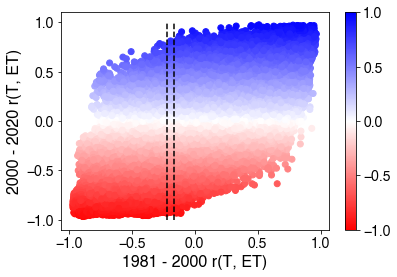

In [292]:
nn_crop_heavy = np.where((data['cf']>0.25))[0]

plt.scatter(data['r_t_et_%s'%y1], data['r_t_et_%s'%y2], c=data['r_t_et_%s'%y2], cmap='bwr_r', vmin=-1, vmax=1)

plt.plot([np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy])], [-1, 1], '--k')
plt.plot([np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy])], [-1, 1], '--k')
         
plt.xlabel('1981 - 2000 r(T, ET)')
plt.ylabel('2000 - 2020 r(T, ET)')
plt.colorbar()

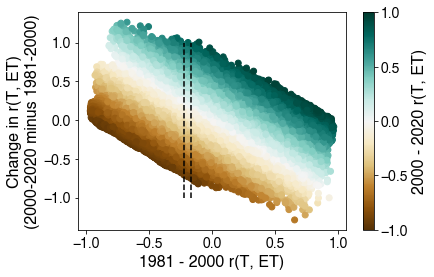

In [293]:
nn_crop_heavy = np.where((data['cf']>0.25))[0]

plt.scatter(data['r_t_et_%s'%y1], data['r_t_et_%s'%y2]-data['r_t_et_%s'%y1], c=data['r_t_et_%s'%y2], cmap='BrBG', vmin=-1, vmax=1)

plt.plot([np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy])], [-1, 1], '--k')
plt.plot([np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy])], [-1, 1], '--k')
         
plt.xlabel('1981 - 2000 r(T, ET)')
plt.ylabel('Change in r(T, ET)\n(2000-2020 minus 1981-2000)')
cb = plt.colorbar()
cb.set_label('2000 - 2020 r(T, ET)')

In [294]:
cf_shift = data['cf'][nn_shift]
cf_above = data['cf'][nn_above]
cf_below = data['cf'][nn_below]

rt_shift = data['r_t_et_%s'%y2][nn_shift]-data['r_t_et_%s'%y1][nn_shift]
rt_above = data['r_t_et_%s'%y2][nn_above]-data['r_t_et_%s'%y1][nn_above]
rt_below = data['r_t_et_%s'%y2][nn_below]-data['r_t_et_%s'%y1][nn_below]

sm_shift = data['sm_during_tx_%d_2'%pct][nn_shift]-data['sm_during_tx_%d_1'%pct][nn_shift]
sm_above = data['sm_during_tx_%d_2'%pct][nn_above]-data['sm_during_tx_%d_1'%pct][nn_above]
sm_below = data['sm_during_tx_%d_2'%pct][nn_below]-data['sm_during_tx_%d_1'%pct][nn_below]

tx_amp_shift = (data['tx_during_tx_95_2'][nn_shift]-data['tx_during_tx_95_1'][nn_shift]) - (data['tx_during_tx_50_2'][nn_shift]-data['tx_during_tx_50_1'][nn_shift])
tx_amp_above = (data['tx_during_tx_95_2'][nn_above]-data['tx_during_tx_95_1'][nn_above]) - (data['tx_during_tx_50_2'][nn_above]-data['tx_during_tx_50_1'][nn_above])
tx_amp_below = (data['tx_during_tx_95_2'][nn_below]-data['tx_during_tx_95_1'][nn_below]) - (data['tx_during_tx_50_2'][nn_below]-data['tx_during_tx_50_1'][nn_below])

tx_shift = data['tx_during_tx_%d_2'%pct][nn_shift]-data['tx_during_tx_%d_1'%pct][nn_shift]
tx_above = data['tx_during_tx_%d_2'%pct][nn_above]-data['tx_during_tx_%d_1'%pct][nn_above]
tx_below = data['tx_during_tx_%d_2'%pct][nn_below]-data['tx_during_tx_%d_1'%pct][nn_below]

et_shift = data['et_during_tx_%d_2'%pct][nn_shift]-data['et_during_tx_%d_1'%pct][nn_shift]
et_above = data['et_during_tx_%d_2'%pct][nn_above]-data['et_during_tx_%d_1'%pct][nn_above]
et_below = data['et_during_tx_%d_2'%pct][nn_below]-data['et_during_tx_%d_1'%pct][nn_below]

tw_shift = data['tw_during_tx_%d_2'%pct][nn_shift]-data['tw_during_tx_%d_1'%pct][nn_shift]
tw_above = data['tw_during_tx_%d_2'%pct][nn_above]-data['tw_during_tx_%d_1'%pct][nn_above]
tw_below = data['tw_during_tx_%d_2'%pct][nn_below]-data['tw_during_tx_%d_1'%pct][nn_below]

tw_during_tw_shift = data['tw_during_tw_%d_2'%pct][nn_shift]-data['tw_during_tw_%d_1'%pct][nn_shift]
tw_during_tw_above = data['tw_during_tw_%d_2'%pct][nn_above]-data['tw_during_tw_%d_1'%pct][nn_above]
tw_during_tw_below = data['tw_during_tw_%d_2'%pct][nn_below]-data['tw_during_tw_%d_1'%pct][nn_below]

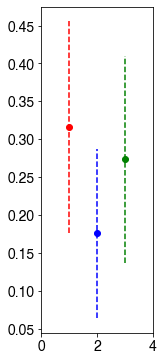

In [295]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(cf_shift), 'or')
plt.plot([1,1], [np.nanmean(cf_shift)-np.nanstd(cf_shift)/2, np.nanmean(cf_shift)+np.nanstd(cf_shift)/2], '--r')
plt.plot(2, np.nanmean(cf_above), 'ob')
plt.plot([2,2], [np.nanmean(cf_above)-np.nanstd(cf_above)/2, np.nanmean(cf_above)+np.nanstd(cf_above)/2], '--b')
plt.plot(3, np.nanmean(cf_below), 'og')
plt.plot([3,3], [np.nanmean(cf_below)-np.nanstd(cf_below)/2, np.nanmean(cf_below)+np.nanstd(cf_below)/2], '--g')

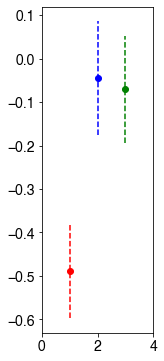

In [296]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(rt_shift), 'or')
plt.plot([1,1], [np.nanmean(rt_shift)-np.nanstd(rt_shift)/2, np.nanmean(rt_shift)+np.nanstd(rt_shift)/2], '--r')
plt.plot(2, np.nanmean(rt_above), 'ob')
plt.plot([2,2], [np.nanmean(rt_above)-np.nanstd(rt_above)/2, np.nanmean(rt_above)+np.nanstd(rt_above)/2], '--b')
plt.plot(3, np.nanmean(rt_below), 'og')
plt.plot([3,3], [np.nanmean(rt_below)-np.nanstd(rt_below)/2, np.nanmean(rt_below)+np.nanstd(rt_below)/2], '--g')

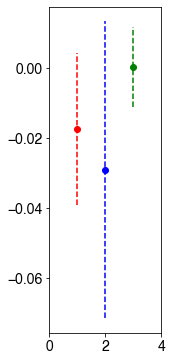

In [297]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(et_shift), 'or')
plt.plot([1,1], [np.nanmean(et_shift)-np.nanstd(et_shift)/2, np.nanmean(et_shift)+np.nanstd(et_shift)/2], '--r')
plt.plot(2, np.nanmean(et_below), 'ob')
plt.plot([2,2], [np.nanmean(et_below)-np.nanstd(et_below)/2, np.nanmean(et_below)+np.nanstd(et_below)/2], '--b')
plt.plot(3, np.nanmean(et_above), 'og')
plt.plot([3,3], [np.nanmean(et_above)-np.nanstd(et_above)/2, np.nanmean(et_above)+np.nanstd(et_above)/2], '--g')

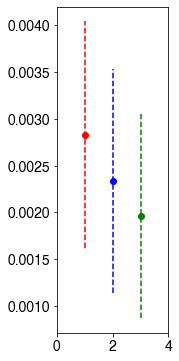

In [298]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(tx_shift), 'or')
plt.plot([1,1], [np.nanmean(tx_shift)-np.nanstd(tx_shift)/2, np.nanmean(tx_shift)+np.nanstd(tx_shift)/2], '--r')
plt.plot(2, np.nanmean(tx_below), 'ob')
plt.plot([2,2], [np.nanmean(tx_below)-np.nanstd(tx_below)/2, np.nanmean(tx_below)+np.nanstd(tx_below)/2], '--b')
plt.plot(3, np.nanmean(tx_above), 'og')
plt.plot([3,3], [np.nanmean(tx_above)-np.nanstd(tx_above)/2, np.nanmean(tx_above)+np.nanstd(tx_above)/2], '--g')

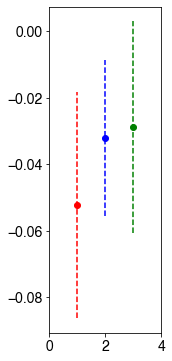

In [299]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(sm_shift), 'or')
plt.plot([1,1], [np.nanmean(sm_shift)-np.nanstd(sm_shift)/2, np.nanmean(sm_shift)+np.nanstd(sm_shift)/2], '--r')
plt.plot(2, np.nanmean(sm_below), 'ob')
plt.plot([2,2], [np.nanmean(sm_below)-np.nanstd(sm_below)/2, np.nanmean(sm_below)+np.nanstd(sm_below)/2], '--b')
plt.plot(3, np.nanmean(sm_above), 'og')
plt.plot([3,3], [np.nanmean(sm_above)-np.nanstd(sm_above)/2, np.nanmean(sm_above)+np.nanstd(sm_above)/2], '--g')


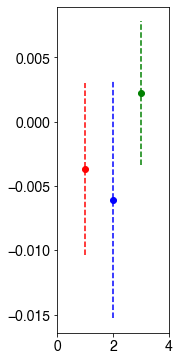

In [300]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(tw_shift), 'or')
plt.plot([1,1], [np.nanmean(tw_shift)-np.nanstd(tw_shift)/2, np.nanmean(tw_shift)+np.nanstd(tw_shift)/2], '--r')
plt.plot(2, np.nanmean(tw_below), 'ob')
plt.plot([2,2], [np.nanmean(tw_below)-np.nanstd(tw_below)/2, np.nanmean(tw_below)+np.nanstd(tw_below)/2], '--b')
plt.plot(3, np.nanmean(tw_above), 'og')
plt.plot([3,3], [np.nanmean(tw_above)-np.nanstd(tw_above)/2, np.nanmean(tw_above)+np.nanstd(tw_above)/2], '--g')

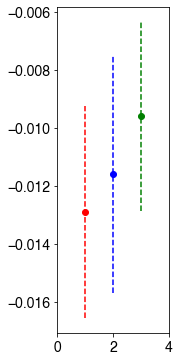

In [301]:
plt.figure(figsize=(2,6))
plt.xlim([0,4])
plt.plot(1, np.nanmean(tx_amp_shift), 'or')
plt.plot([1,1], [np.nanmean(tx_amp_shift)-np.nanstd(tx_amp_shift)/2, np.nanmean(tx_amp_shift)+np.nanstd(tx_amp_shift)/2], '--r')
plt.plot(2, np.nanmean(tx_amp_below), 'ob')
plt.plot([2,2], [np.nanmean(tx_amp_below)-np.nanstd(tx_amp_below)/2, np.nanmean(tx_amp_below)+np.nanstd(tx_amp_below)/2], '--b')
plt.plot(3, np.nanmean(tx_amp_above), 'og')
plt.plot([3,3], [np.nanmean(tx_amp_above)-np.nanstd(tx_amp_above)/2, np.nanmean(tx_amp_above)+np.nanstd(tx_amp_above)/2], '--g')

In [302]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)

# coefs_cf = []
# coefs_rt = []
# coefs_rt_diff = []

# pvals_cf = []
# pvals_rt = []
# pvals_rt_diff = []

# mdl_r2 = []

# for c, cur_bin in enumerate(cf_bins):

#     if c == 0:
#         ind_cf_all = np.where((data['cf'] < .01))[0]
#     elif c == cf_bins.size-1:
#         ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step))[0]
#     else:
#         ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin))[0]

#     mdl_cur = smf.ols(formula='tx_during_tx_diff ~ cf + r_t_et + r_t_et_diff', data=df, subset = ind_cf_all).fit()
    
#     mdl_r2.append(mdl_cur.rsquared)
    
#     coefs_cf.append(mdl_cur.params['cf'])
#     coefs_rt.append(mdl_cur.params['r_t_et'])
#     coefs_rt_diff.append(mdl_cur.params['r_t_et_diff'])
    
#     pvals_cf.append(mdl_cur.pvalues['cf'])
#     pvals_rt.append(mdl_cur.pvalues['r_t_et'])
#     pvals_rt_diff.append(mdl_cur.pvalues['r_t_et_diff'])

In [303]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)

# r_t_et_bins = np.arange(-.5, .51, .1)
# r_t_et_diff_bins = np.arange(-.5, .51, .1)

# chg_from_r_t_et_diff = {}
# chg_from_r_t_et = {}
# chg_from_cf = {}

# for c, cur_cf_bin in enumerate(cf_bins):
#     if c == 0:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] < .01)))[0]
#     elif c == cf_bins.size-1:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step)))[0]
#     else:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step) & (data['cf'] < cur_cf_bin)))[0]
    
    
#     chg_from_r_t_et_diff[c] = data['r_t_et_diff'][ind_cf]*coefs_rt_diff[c]
#     chg_from_r_t_et[c] = data['r_t_et'][ind_cf]*coefs_rt[c]
#     chg_from_cf[c] = data['cf'][ind_cf]*coefs_cf[c]

In [304]:
# fig, ax = plt.subplots(1,3, figsize=(14,4))

# t = 'Tx during Tx'

# ax[0].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[1].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[2].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')

# for i, val in enumerate(coefs_cf):
#     if pvals_cf[i] < .05:
#         ax[0].plot([i, i], [np.nanmean(chg_from_cf[i])-np.nanstd(chg_from_cf[i])/2, np.nanmean(chg_from_cf[i])+np.nanstd(chg_from_cf[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[0].plot(i, np.nanmean(chg_from_cf[i]), 'og', markersize=10)
        
#     else:
#         ax[0].plot(i, np.nanmean(chg_from_cf[i]), 'or', markersize=10)
        
        
#     if pvals_rt[i] < .05:
#         ax[1].plot([i, i], [np.nanmean(chg_from_r_t_et[i])-np.nanstd(chg_from_r_t_et[i])/2, np.nanmean(chg_from_r_t_et[i])+np.nanstd(chg_from_r_t_et[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[1].plot(i, np.nanmean(chg_from_r_t_et[i]), 'og', markersize=10)
        
#     else:
#         ax[1].plot(i, np.nanmean(chg_from_r_t_et[i]), 'or', markersize=10)
        
#     if pvals_rt_diff[i] < .05:
#         ax[2].plot([i, i], [np.nanmean(chg_from_r_t_et_diff[i])-np.nanstd(chg_from_r_t_et_diff[i])/2, np.nanmean(chg_from_r_t_et_diff[i])+np.nanstd(chg_from_r_t_et_diff[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[2].plot(i, np.nanmean(chg_from_r_t_et_diff[i]), 'og', markersize=10)
        
#     else:
#         ax[2].plot(i, np.nanmean(chg_from_r_t_et_diff[i]), 'or', markersize=10)
                

# ax[0].set_ylabel('%s change\nfrom mean crop fraction'%t)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_xticks(range(cf_bins.size))
# ax[0].set_xticklabels(np.round(cf_bins, 1))


# ax[1].set_ylabel('%s change\nfrom mean r(T, ET)'%t)
# ax[1].set_xlabel('Crop fraction')
# ax[1].set_xticks(range(cf_bins.size))
# ax[1].set_xticklabels(np.round(cf_bins, 1))



# ax[2].set_ylabel('%s change\nfrom change in r(T, ET)'%t)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_xticks(range(cf_bins.size))
# ax[2].set_xticklabels(np.round(cf_bins, 1))

# plt.tight_layout()

# # plt.savefig('tw-during-tx-trend-drivers.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [305]:
# fig, ax = plt.subplots(1,3, figsize=(13,4))

# t = 'Tw during Tx'

# for i, val in enumerate(coefs_cf):
#     if pvals_cf[i] < .05:
#         ax[0].plot(i, val, 'og', markersize=10)
#     else:
#         ax[0].plot(i, val, 'or', markersize=10)
# ax[0].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[0].set_ylabel('%s change\nper mean crop fraction'%t)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_xticks(range(cf_bins.size))
# ax[0].set_xticklabels(np.round(cf_bins, 1))

# for i, val in enumerate(coefs_rt):
#     if pvals_rt[i] < .05:
#         ax[1].plot(i, val, 'og', markersize=10)
#     else:
#         ax[1].plot(i, val, 'or', markersize=10)
# ax[1].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[1].set_ylabel('%s change\nper mean r(T, ET)'%t)
# ax[1].set_xlabel('Crop fraction')
# ax[1].set_xticks(range(cf_bins.size))
# ax[1].set_xticklabels(np.round(cf_bins, 1))


# for i, val in enumerate(coefs_rt_diff):
#     if pvals_rt_diff[i] < .05:
#         ax[2].plot(i, val, 'og', markersize=10)
#     else:
#         ax[2].plot(i, val, 'or', markersize=10)
# ax[2].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[2].set_ylabel('%s change\nper change in r(T, ET)'%t)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_xticks(range(cf_bins.size))
# ax[2].set_xticklabels(np.round(cf_bins, 1))

# plt.tight_layout()

# # plt.savefig('tw-during-tx-trend-coefs.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [306]:
cf_chg_bin_step = .02
cf_chg_bins = np.arange(-.1, .11, cf_chg_bin_step)

gridcell_ct = []

r_t_et_by_cf_chg_bin = {}
r_t_et_1_by_cf_chg_bin = {}
r_t_et_2_by_cf_chg_bin = {}
r_t_et_3_by_cf_chg_bin = {}

tx_during_tx_by_cf_chg_bin_1 = np.full([percentiles.size, cf_chg_bins.size], np.nan)
tx_during_tx_by_cf_chg_bin_2 = np.full([percentiles.size, cf_chg_bins.size], np.nan)

tx_during_tx_trend_by_cf_chg_bin = np.full([cf_chg_bins.size], np.nan)

et_during_tx_by_cf_chg_bin_1 = np.full([percentiles.size, cf_chg_bins.size], np.nan)
et_during_tx_by_cf_chg_bin_2 = np.full([percentiles.size, cf_chg_bins.size], np.nan)

sm_during_tx_by_cf_chg_bin_1 = np.full([percentiles.size, cf_chg_bins.size], np.nan)
sm_during_tx_by_cf_chg_bin_2 = np.full([percentiles.size, cf_chg_bins.size], np.nan)


huss_during_tx_by_cf_chg_bin = []
huss_during_tx_by_cf_chg_bin_1 = []
huss_during_tx_by_cf_chg_bin_2 = []

tw_during_tx_by_cf_chg_bin_1 = np.full([percentiles.size, cf_chg_bins.size], np.nan)
tw_during_tx_by_cf_chg_bin_2 = np.full([percentiles.size, cf_chg_bins.size], np.nan)

tw_during_tw_by_cf_chg_bin_1 = np.full([percentiles.size, cf_chg_bins.size], np.nan)
tw_during_tw_by_cf_chg_bin_2 = np.full([percentiles.size, cf_chg_bins.size], np.nan)


sacks_start_by_cf_chg_bin = []
sacks_end_by_cf_chg_bin = []

cf_var = 'wheat_ha_chg'

for c, cur_bin in enumerate(cf_chg_bins):
    
    if c == 0:
        nn = np.where((data[cf_var] < cf_chg_bins[0]) & (data[cf_var] != 0))[0]
    elif c == cf_chg_bins.size-1:
        nn = np.where((data[cf_var] > cf_chg_bins[-1]-cf_chg_bin_step) & (data[cf_var] != 0))[0]
    else:
        nn = np.where(((data[cf_var] > cur_bin-cf_chg_bin_step) & (data[cf_var] <= cur_bin) & (data[cf_var] != 0)))[0]
    
    gridcell_ct.append(nn.size)
    
    sacks_start_by_cf_chg_bin.append(np.nanmean(data['sacks_start'][nn]))
    sacks_end_by_cf_chg_bin.append(np.nanmean(data['sacks_end'][nn]))
    
    r_t_et_by_cf_chg_bin[c] = data['r_t_et'][nn]
    r_t_et_1_by_cf_chg_bin[c] = data['r_t_et_1'][nn]
    r_t_et_2_by_cf_chg_bin[c] = data['r_t_et_2'][nn]
    r_t_et_3_by_cf_chg_bin[c] = data['r_t_et_3'][nn]
    
    for p in range(percentiles.size):
        tx_during_tx_by_cf_chg_bin_1[p, c] = np.nanmean(data['tx_during_tx_%d_1'%percentiles[p]][nn])
        tx_during_tx_by_cf_chg_bin_2[p, c] = np.nanmean(data['tx_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'tw_during_tx_%d_1'%percentiles[p] in data.keys():
            tw_during_tx_by_cf_chg_bin_1[p, c] = np.nanmean(data['tw_during_tx_%d_1'%percentiles[p]][nn])
            tw_during_tx_by_cf_chg_bin_2[p, c] = np.nanmean(data['tw_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'et_during_tx_%d_1'%percentiles[p] in data.keys():
            et_during_tx_by_cf_chg_bin_1[p, c] = np.nanmean(data['et_during_tx_%d_1'%percentiles[p]][nn])
            et_during_tx_by_cf_chg_bin_2[p, c] = np.nanmean(data['et_during_tx_%d_2'%percentiles[p]][nn])
            
        if 'sm_during_tx_%d_1'%percentiles[p] in data.keys():
            sm_during_tx_by_cf_chg_bin_1[p, c] = np.nanmean(data['sm_during_tx_%d_1'%percentiles[p]][nn])
            sm_during_tx_by_cf_chg_bin_2[p, c] = np.nanmean(data['sm_during_tx_%d_2'%percentiles[p]][nn])

            
            
        if 'tw_during_tw_%d_1'%percentiles[p] in data.keys():
            tw_during_tw_by_cf_chg_bin_1[p, c] = np.nanmean(data['tw_during_tw_%d_1'%percentiles[p]][nn])
            tw_during_tw_by_cf_chg_bin_2[p, c] = np.nanmean(data['tw_during_tw_%d_2'%percentiles[p]][nn])
   
    tx_during_tx_trend_by_cf_chg_bin[c] = np.nanmean(data['tx_during_tx_trend'][nn])

    huss_during_tx_by_cf_chg_bin_1.append(np.nanmean(data['huss_during_tx_1'][nn]))
    huss_during_tx_by_cf_chg_bin_2.append(np.nanmean(data['huss_during_tx_2'][nn]))
    

    

KeyError: 'r_t_et'

In [ ]:
up_ind = np.where(data[cf_var]>0)[0]
down_ind = np.where(data[cf_var]<0)[0]

In [ ]:
pct=95
chg_up = np.nanmean(data['tx_during_tx_%d_2'%pct][up_ind])-np.nanmean(data['tx_during_tx_%d_1'%pct][up_ind])
chg_down = np.nanmean(data['tx_during_tx_%d_2'%pct][down_ind])-np.nanmean(data['tx_during_tx_%d_1'%pct][down_ind])
chg_up-chg_down

In [ ]:
gridcell_ct

In [ ]:
pct=95
plt.plot(cf_chg_bins, [np.nanmean(r_t_et_2_by_cf_chg_bin[x]) for x in r_t_et_2_by_cf_chg_bin.keys()], 'b')
plt.plot(cf_chg_bins, [np.nanmean(r_t_et_3_by_cf_chg_bin[x]) for x in r_t_et_3_by_cf_chg_bin.keys()], 'r')

In [ ]:
pct=95
plt.plot(cf_chg_bins, tx_during_tx_by_cf_chg_bin_2[np.where(percentiles==pct)[0],:][0]-tx_during_tx_by_cf_chg_bin_1[np.where(percentiles==pct)[0],:][0])

In [ ]:

plt.plot(cf_chg_bins, et_during_tx_by_cf_chg_bin_2[np.where(percentiles==pct)[0],:][0]-et_during_tx_by_cf_chg_bin_1[np.where(percentiles==pct)[0],:][0])

In [ ]:

plt.plot(cf_chg_bins, sm_during_tx_by_cf_chg_bin_2[np.where(percentiles==pct)[0],:][0]-sm_during_tx_by_cf_chg_bin_1[np.where(percentiles==pct)[0],:][0])

In [ ]:
cf_bin_step = .1
cf_bins = np.arange(0, 1.01, cf_bin_step)

gridcell_ct = []

r_t_et_61_81_by_cf_bin = {}
r_t_et_71_91_by_cf_bin = {}
r_t_et_81_01_by_cf_bin = {}
r_t_et_91_11_by_cf_bin = {}
r_t_et_01_21_by_cf_bin = {}

tx_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tx_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

tx_during_tx_trend_by_cf_bin = np.full([cf_bins.size], np.nan)

et_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
et_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

sm_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
sm_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)


huss_during_tx_by_cf_bin = []
huss_during_tx_by_cf_bin_1 = []
huss_during_tx_by_cf_bin_2 = []

tw_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tw_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

tw_during_tw_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tw_during_tw_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)


sacks_start_by_cf_bin = []
sacks_end_by_cf_bin = []

cf_var = 'cf'

for c, cur_bin in enumerate(cf_bins):
    
    if c == 0:
        nn = np.where((data[cf_var] < .01))[0]
    elif c == cf_bins.size-1:
        nn = np.where((data[cf_var] > cur_bin-cf_bin_step))[0]
    else:
        nn = np.where(((data[cf_var] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin)))[0]
    
    gridcell_ct.append(nn.size)
    
    sacks_start_by_cf_bin.append(np.nanmean(data['sacks_start'][nn]))
    sacks_end_by_cf_bin.append(np.nanmean(data['sacks_end'][nn]))
    
    r_t_et_61_81_by_cf_bin[c] = data['r_t_et_61_81'][nn]
    r_t_et_71_91_by_cf_bin[c] = data['r_t_et_71_91'][nn]
    r_t_et_81_01_by_cf_bin[c] = data['r_t_et_81_01'][nn]
    r_t_et_91_11_by_cf_bin[c] = data['r_t_et_91_11'][nn]
    r_t_et_01_21_by_cf_bin[c] = data['r_t_et_01_21'][nn]
    
    for p in range(percentiles.size):
        tx_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['tx_during_tx_%d_1'%percentiles[p]][nn])
        tx_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['tx_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'tw_during_tx_%d_1'%percentiles[p] in data.keys():
            tw_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['tw_during_tx_%d_1'%percentiles[p]][nn])
            tw_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['tw_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'et_during_tx_%d_1'%percentiles[p] in data.keys():
            et_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['et_during_tx_%d_1'%percentiles[p]][nn])
            et_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['et_during_tx_%d_2'%percentiles[p]][nn])
            
        if 'sm_during_tx_%d_1'%percentiles[p] in data.keys():
            sm_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['sm_during_tx_%d_1'%percentiles[p]][nn])
            sm_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['sm_during_tx_%d_2'%percentiles[p]][nn])

            
            
        if 'tw_during_tw_%d_1'%percentiles[p] in data.keys():
            tw_during_tw_by_cf_bin_1[p, c] = np.nanmean(data['tw_during_tw_%d_1'%percentiles[p]][nn])
            tw_during_tw_by_cf_bin_2[p, c] = np.nanmean(data['tw_during_tw_%d_2'%percentiles[p]][nn])
   
    tx_during_tx_trend_by_cf_bin[c] = np.nanmean(data['tx_during_tx_trend'][nn])

    huss_during_tx_by_cf_bin_1.append(np.nanmean(data['huss_during_tx_1'][nn]))
    huss_during_tx_by_cf_bin_2.append(np.nanmean(data['huss_during_tx_2'][nn]))
    

    

In [ ]:
# divide up grid cells by sacks bin

pct = 95

sacks_start_bins = np.arange(130, 150, 2)
sacks_end_bins = np.arange(240, 270, 3)

tx_during_tx_chg_by_sacks_start = []
tx_during_tx_chg_by_sacks_end = []

for b, cur_bin in enumerate(sacks_start_bins):
    nn = np.where((data['sacks_start'] >= cur_bin) &  (data['sacks_start'] < cur_bin+2))[0]
    tx_during_tx_chg_by_sacks_start.append(np.nanmean(data['tx_during_tx_%d_2'%pct][nn]-data['tx_during_tx_%d_1'%pct][nn]))
    
    nn = np.where((data['sacks_end'] >= cur_bin) &  (data['sacks_end'] < cur_bin+3))[0]
    tx_during_tx_chg_by_sacks_end.append(np.nanmean(data['tx_during_tx_%d_2'%pct][nn]-data['tx_during_tx_%d_1'%pct][nn]))


In [ ]:
plt.plot(tx_during_tx_chg_by_sacks_end)

In [ ]:
plt.plot(sacks_end_by_cf_bin-np.nanmean(sacks_end_by_cf_bin), 'or')
plt.plot(sacks_start_by_cf_bin-np.nanmean(sacks_start_by_cf_bin), 'og')

In [ ]:
pct = 95

tw_during_tw_chg_binned = tw_during_tw_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tw_during_tw_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(tw_during_tw_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tw_during_tw_chg_binned[nn], X).fit()

x1 = -.18
x2 = -.02

plt.figure(figsize=(6,6))

plt.scatter(r_t_et_chg_binned[nn], tw_during_tw_chg_binned[nn], c='#db8e30', s=100)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in Tw\nduring extreme Tw (Percentile)')
plt.legend(prop={'size': 18}, frameon=False)
# plt.savefig('chg-sm-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
pct = 95

et_during_tx_chg_binned = et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = -.18
x2 = -.02

plt.figure(figsize=(6,6))

plt.scatter(r_t_et_chg_binned[nn], et_during_tx_chg_binned[nn], c='#db8e30', s=100)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in ET\nduring extreme Tx (Percentile)')
plt.legend(prop={'size': 18}, frameon=False)
# plt.savefig('chg-sm-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
pct = 95

tw_during_tx_chg_binned = tw_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tw_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(tw_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tw_during_tx_chg_binned[nn], X).fit()

x1 = -.18
x2 = -.02

plt.figure(figsize=(6,6))

plt.scatter(r_t_et_chg_binned[nn], tw_during_tx_chg_binned[nn], c='#db8e30', s=100)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in Tw\nduring extreme Tx (Percentile)')
plt.legend(prop={'size': 18}, frameon=False)
# plt.savefig('chg-sm-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
pct = 95

sm_during_tx_chg_binned = sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -.18
x2 = -.02

plt.figure(figsize=(6,6))

plt.scatter(r_t_et_chg_binned[nn], sm_during_tx_chg_binned[nn], c='#db8e30', s=100)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in soil moisture\nduring extreme Tx (Percentile)')
plt.legend(prop={'size': 18}, frameon=False)
# plt.savefig('chg-sm-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

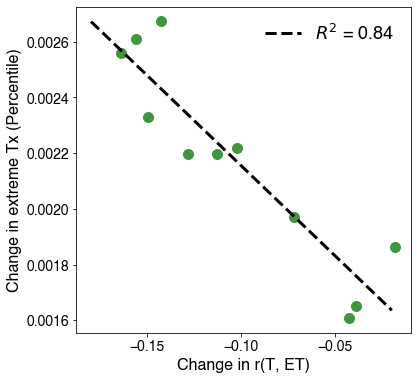

In [183]:
pct = 95

tx_during_tx_chg_binned = tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()

x1 = -.18
x2 = -.02

plt.figure(figsize=(6,6))

plt.scatter(r_t_et_chg_binned, tx_during_tx_chg_binned, c='#439441', s=100)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in extreme Tx (Percentile)')
plt.legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

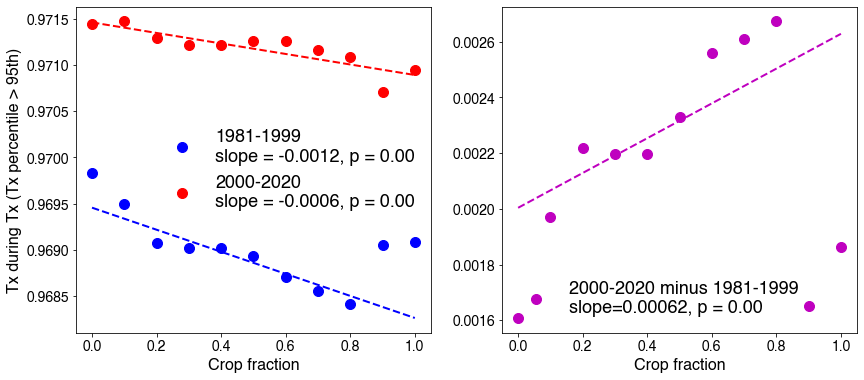

In [275]:
pct = 95
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tx_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tx_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['tx_during_tx_%d_2'%pct]-data['tx_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx during Tx (Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

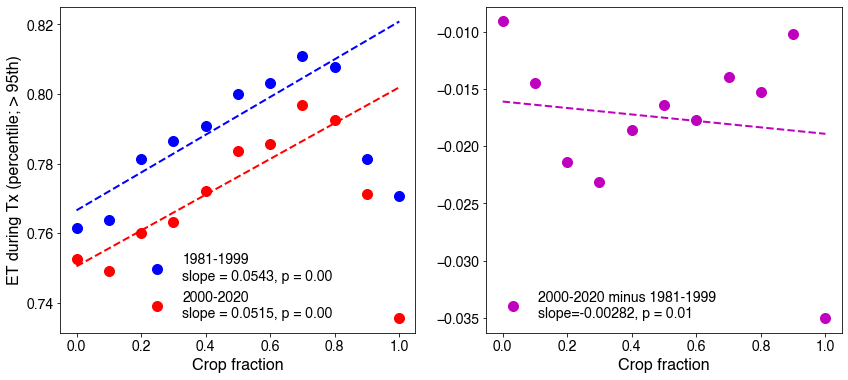

In [276]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['et_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['et_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['et_during_tx_%d_2'%pct]-data['et_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('ET during Tx (percentile; > 95th)')
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

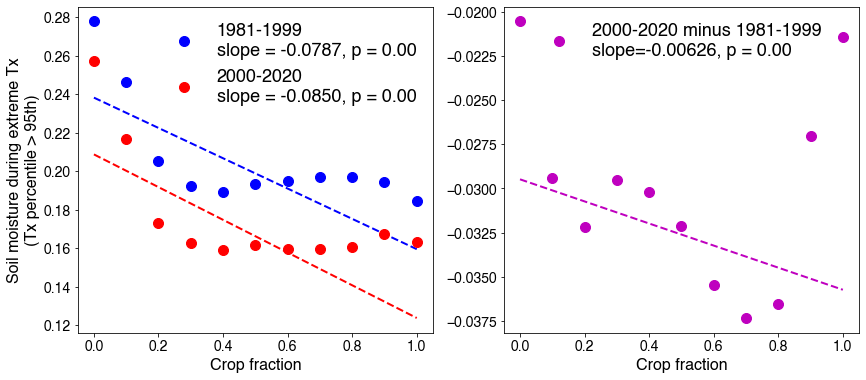

In [277]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['sm_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['sm_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['sm_during_tx_%d_2'%pct]-data['sm_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Soil moisture during extreme Tx\n(Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-sm-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

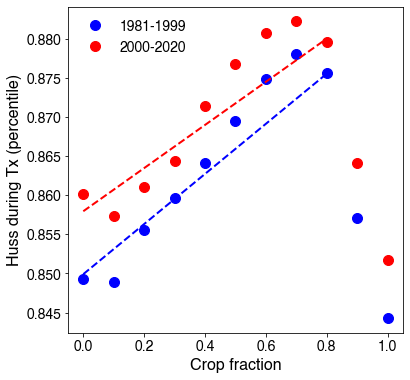

In [278]:
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['huss_during_tx_1'], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['huss_during_tx_2'], X).fit()


plt.figure(figsize=(6,6))

plt.plot(cf_bins, huss_during_tx_by_cf_bin_1, 'ob', markersize=10, label='1981-1999')
plt.plot([0, .8], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+0.8*mdl_1.params[1]], '--b', lw=2)

plt.plot(cf_bins, huss_during_tx_by_cf_bin_2, 'or', markersize=10, label='2000-2020')
plt.plot([0, .8], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+0.8*mdl_2.params[1]], '--r', lw=2)

# plt.plot(cf_bins, et_during_tx_by_cf_bin, 'om', markersize=10, label='1981-2020')
    
# plt.gca().set_xticks(range(0,cf_bins.size,2))
# plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('Huss during Tx (percentile)')
plt.legend(prop={'size': 14}, frameon=False)

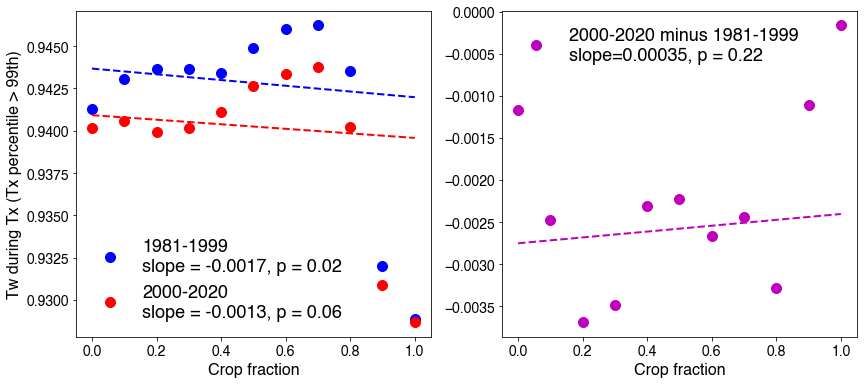

In [279]:
pct = 99
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tw_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tw_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['tw_during_tx_%d_2'%pct]-data['tw_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, tw_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, tw_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tw during Tx (Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, tw_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tw_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [280]:
cf_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

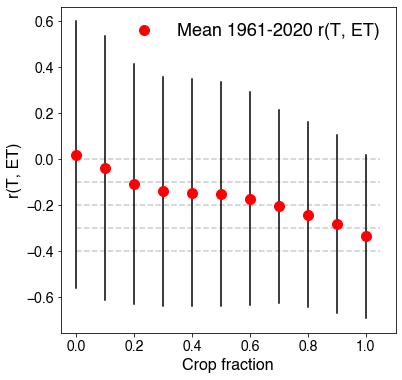

In [190]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.4, -.4], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_by_cf_bin.keys()):
    m = np.nanmean(r_t_et_by_cf_bin[k])
    sdev = np.nanstd(r_t_et_by_cf_bin[k])
    plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m, 'or', markersize=10, label='Mean 1961-2020 r(T, ET)')
    else:
        plt.plot(k, m, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 18}, frameon=False, loc='upper right')

# plt.savefig('mean-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

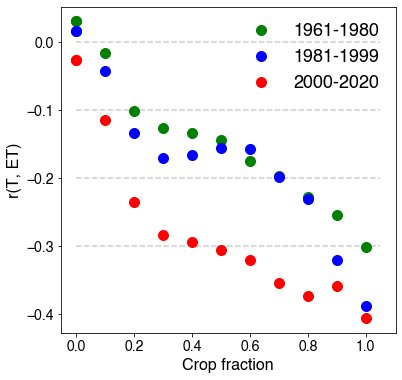

In [189]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_1_by_cf_bin.keys()):
    m1 = np.nanmean(r_t_et_61_81_by_cf_bin[k])
    sdev1 = np.nanstd(r_t_et_81_01_by_cf_bin[k])
    
    m2 = np.nanmean(r_t_et_81_01_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_81_01_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_01_21_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_01_21_by_cf_bin[k])
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m1, 'og', markersize=10, label='1961-1980')
        plt.plot(k, m2, 'ob', markersize=10, label='1981-1999')
        plt.plot(k, m3, 'or', markersize=10, label='2000-2020')
        
    plt.plot(k, m1, 'og', markersize=10)
    plt.plot(k, m2, 'ob', markersize=10)
    plt.plot(k, m3, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 18}, frameon=False, loc='upper right')

# plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


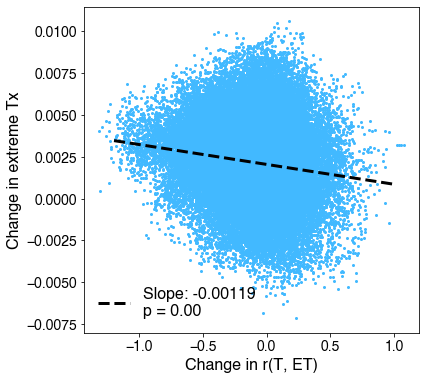

In [284]:
tx_during_tx_95_chg = data['tx_during_tx_%d_2'%95]-data['tx_during_tx_%d_1'%95]
r_t_et_chg = data['r_t_et_3'] - data['r_t_et_2']
# r_t_et_chg = data['sm_during_tx_%d_2'%95]-data['sm_during_tx_%d_1'%95]

nn = np.where((~np.isnan(r_t_et_chg)) & (~np.isnan(tx_during_tx_95_chg)))[0]

X = sm.add_constant(r_t_et_chg[nn])
mdl = sm.OLS(tx_during_tx_95_chg[nn], X).fit()


x1 = -1.2
x2 = 1
plt.figure(figsize=(6,6))
plt.scatter(r_t_et_chg, tx_during_tx_95_chg, c='#42b9ff', s=4)
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=3, label='Slope: %.5f\np = %.2f'%(mdl.params[1], mdl.pvalues[1]))
plt.xlabel('Change in r(T, ET)')
plt.ylabel('Change in extreme Tx')
plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

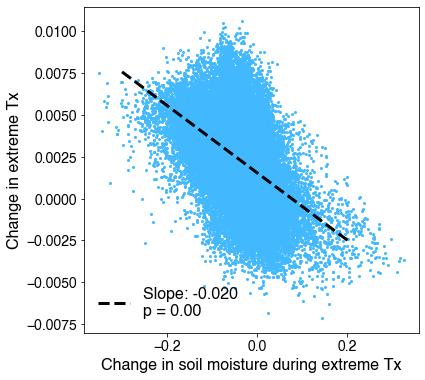

In [285]:
tx_during_tx_95_chg = data['tx_during_tx_%d_2'%95]-data['tx_during_tx_%d_1'%95]
sm_during_tx_95_chg = data['sm_during_tx_%d_2'%95]-data['sm_during_tx_%d_1'%95]
r_t_et_chg = data['r_t_et_3'] - data['r_t_et_2']
nn = np.where((~np.isnan(tx_during_tx_95_chg)) & (~np.isnan(sm_during_tx_95_chg)))[0]

X = sm.add_constant(sm_during_tx_95_chg[nn])
mdl = sm.OLS(tx_during_tx_95_chg[nn], X).fit()


x1 = -.3
x2 = .2
plt.figure(figsize=(6,6))
plt.scatter(sm_during_tx_95_chg, tx_during_tx_95_chg, c='#42b9ff', s=4)
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=3, label='Slope: %.3f\np = %.2f'%(mdl.params[1], mdl.pvalues[1]))
plt.xlabel('Change in soil moisture during extreme Tx')
plt.ylabel('Change in extreme Tx')
plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

Text(0, 0.5, 'Change in ET during extreme Tx')

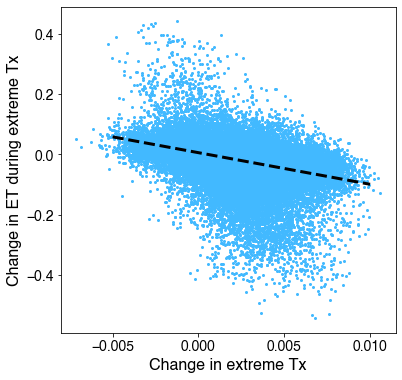

In [286]:
tx_during_tx_95_chg = data['tx_during_tx_%d_2'%95]-data['tx_during_tx_%d_1'%95]
et_during_tx_95_chg = data['et_during_tx_%d_2'%95]-data['et_during_tx_%d_1'%95]

nn = np.where((~np.isnan(tx_during_tx_95_chg)) & (~np.isnan(et_during_tx_95_chg)))[0]

X = sm.add_constant(tx_during_tx_95_chg[nn])
mdl = sm.OLS(et_during_tx_95_chg[nn], X).fit()


x1 = -.005
x2 = .01
plt.figure(figsize=(6,6))
plt.scatter(tx_during_tx_95_chg, et_during_tx_95_chg, c='#42b9ff', s=4)
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=3)
plt.xlabel('Change in extreme Tx')
plt.ylabel('Change in ET during extreme Tx')

In [287]:
cf_bin_step = .1
cf_bins = np.arange(0, .81, cf_bin_step)

r_t_et_bins = np.arange(-.5, .51, .1)
r_t_et_diff_bins = np.arange(-.5, .51, .1)


# find grid cells with given r_t_et and no crops vs crops

tx_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)


tx_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
et_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
huss_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
tw_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)

tx_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):

    ind_r_t_et = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin) & (data['r_t_et'] < cur_r_t_et_bin+.1)))[0]
    
    tx_during_tx_rt_binned[r] = np.nanmean(data['tx_during_tx'][ind_r_t_et])
    et_during_tx_rt_binned[r] = np.nanmean(data['et_during_tx'][ind_r_t_et])
    huss_during_tx_rt_binned[r] = np.nanmean(data['huss_during_tx'][ind_r_t_et])
    tw_during_tx_rt_binned[r] = np.nanmean(data['tw_during_tx'][ind_r_t_et])

    tx_during_tx_trend_rt_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et])
    et_during_tx_trend_rt_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et])
    huss_during_tx_trend_rt_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et])
    tw_during_tx_trend_rt_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et])
    
    tx_during_tw_rt_binned[r] = np.nanmean(data['tx_during_tw'][ind_r_t_et])
    et_during_tw_rt_binned[r] = np.nanmean(data['et_during_tw'][ind_r_t_et])
    huss_during_tw_rt_binned[r] = np.nanmean(data['huss_during_tw'][ind_r_t_et])
    tw_during_tw_rt_binned[r] = np.nanmean(data['tw_during_tw'][ind_r_t_et])

    tx_during_tw_trend_rt_binned[r] = np.nanmean(data['tx_during_tw_trend'][ind_r_t_et])
    et_during_tw_trend_rt_binned[r] = np.nanmean(data['et_during_tw_trend'][ind_r_t_et])
    huss_during_tw_trend_rt_binned[r] = np.nanmean(data['huss_during_tw_trend'][ind_r_t_et])
    tw_during_tw_trend_rt_binned[r] = np.nanmean(data['tw_during_tw_trend'][ind_r_t_et])
    
    for c, cur_bin in enumerate(cf_bins):

        if c == 0:
            ind_cf = np.where((data['cf'][ind_r_t_et] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf = np.where((data['cf'][ind_r_t_et] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf = np.where((data['cf'][ind_r_t_et] > cur_bin-cf_bin_step) & (data['cf'][ind_r_t_et] <= cur_bin))[0]
            
        if c == 0:
            ind_cf_all = np.where((data['cf'] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin))[0]
        
        if ind_cf.size > 10:
            if r == 0:
                tx_during_tx_cf_binned[c] = np.nanmean(data['tx_during_tx'][ind_cf_all])
                et_during_tx_cf_binned[c] = np.nanmean(data['et_during_tx'][ind_cf_all])
                huss_during_tx_cf_binned[c] = np.nanmean(data['huss_during_tx'][ind_cf_all])
                tw_during_tx_cf_binned[c] = np.nanmean(data['tw_during_tx'][ind_cf_all])

                tx_during_tx_trend_cf_binned[c] = np.nanmean(data['tx_during_tx_trend'][ind_cf_all])
                et_during_tx_trend_cf_binned[c] = np.nanmean(data['et_during_tx_trend'][ind_cf_all])
                huss_during_tx_trend_cf_binned[c] = np.nanmean(data['huss_during_tx_trend'][ind_cf_all])
                tw_during_tx_trend_cf_binned[c] = np.nanmean(data['tw_during_tx_trend'][ind_cf_all])
                
                tx_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['tx_during_tx_trend_zonal'][ind_cf_all])
                et_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['et_during_tx_trend_zonal'][ind_cf_all])
                huss_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['huss_during_tx_trend_zonal'][ind_cf_all])
                tw_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['tw_during_tx_trend_zonal'][ind_cf_all])
                
                tx_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['tx_during_tw_trend_zonal'][ind_cf_all])
                et_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['et_during_tw_trend_zonal'][ind_cf_all])
                huss_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['huss_during_tw_trend_zonal'][ind_cf_all])
                tw_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['tw_during_tw_trend_zonal'][ind_cf_all])
                
                tx_during_tw_cf_binned[c] = np.nanmean(data['tx_during_tw'][ind_cf_all])
                et_during_tw_cf_binned[c] = np.nanmean(data['et_during_tw'][ind_cf_all])
                huss_during_tw_cf_binned[c] = np.nanmean(data['huss_during_tw'][ind_cf_all])
                tw_during_tw_cf_binned[c] = np.nanmean(data['tw_during_tw'][ind_cf_all])

                tx_during_tw_trend_cf_binned[c] = np.nanmean(data['tx_during_tw_trend'][ind_cf_all])
                et_during_tw_trend_cf_binned[c] = np.nanmean(data['et_during_tw_trend'][ind_cf_all])
                huss_during_tw_trend_cf_binned[c] = np.nanmean(data['huss_during_tw_trend'][ind_cf_all])
                tw_during_tw_trend_cf_binned[c] = np.nanmean(data['tw_during_tw_trend'][ind_cf_all])
            
            tx_during_tx_2d_binned[c, r] = np.nanmean(data['tx_during_tx'][ind_r_t_et][ind_cf])
            et_during_tx_2d_binned[c, r] = np.nanmean(data['et_during_tx'][ind_r_t_et][ind_cf])
            huss_during_tx_2d_binned[c, r] = np.nanmean(data['huss_during_tx'][ind_r_t_et][ind_cf])
            tw_during_tx_2d_binned[c, r] = np.nanmean(data['tw_during_tx'][ind_r_t_et][ind_cf])
            
            tx_during_tx_trend_2d_binned[c, r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et][ind_cf])
            et_during_tx_trend_2d_binned[c, r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et][ind_cf])
            huss_during_tx_trend_2d_binned[c, r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et][ind_cf])
            tw_during_tx_trend_2d_binned[c, r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et][ind_cf])


            
tx_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)

tx_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)

for r, cur_r_t_et_diff_bin in enumerate(r_t_et_diff_bins):
    if r == 0:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] < cur_r_t_et_diff_bin)))[0]
    elif r == r_t_et_diff_bins.size-1:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] >= cur_r_t_et_diff_bin)))[0]
    else:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] >= cur_r_t_et_diff_bin) & (data['r_t_et_diff'] < cur_r_t_et_diff_bin+.1)))[0]
    
    
    cur_cf_bins = np.full([ind_r_t_et_diff.size], np.nan)
    cur_rt_bins = np.full([ind_r_t_et_diff.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_r_t_et_diff):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff[nn]] - tx_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff[nn]] - tx_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff[nn]] - et_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff[nn]] - et_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff[nn]] - huss_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff[nn]] - huss_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff[nn]] - tw_during_tx_trend_cf_binned[cur_cf_bins[nn]]) + \
                                                np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff[nn]] - tw_during_tx_trend_rt_binned[cur_rt_bins[nn]])
    
    
    tx_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff])
        
    et_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff])
        
    huss_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff])
        
    tw_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff])
        
        
tx_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
            
for c, cur_cf_bin in enumerate(cf_bins):
    if c == 0:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] < .01)))[0]
    elif c == cf_bins.size-1:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step)))[0]
    else:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step) & (data['cf'] < cur_cf_bin)))[0]
    
    cur_cf_bins = np.full([ind_cf.size], np.nan)
    cur_rt_bins = np.full([ind_cf.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_cf):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['tx_during_tx_trend'][ind_cf[nn]] - tx_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['et_during_tx_trend'][ind_cf[nn]] - et_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['huss_during_tx_trend'][ind_cf[nn]] - huss_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['tw_during_tx_trend'][ind_cf[nn]] - tw_during_tx_trend_rt_binned[cur_rt_bins[nn]])
    
    
    tx_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['tx_during_tw_trend'][ind_cf[nn]] - tx_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['et_during_tw_trend'][ind_cf[nn]] - et_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['huss_during_tw_trend'][ind_cf[nn]] - huss_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['tw_during_tw_trend'][ind_cf[nn]] - tw_during_tw_trend_rt_binned[cur_rt_bins[nn]])

    
    
tx_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):
    if r == 0:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] < cur_r_t_et_bin))[0]
    elif r == r_t_et_diff_bins.size-1:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin))[0]
    else:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin) & (data['r_t_et'] < cur_r_t_et_bin+.1))[0]
    
    cur_cf_bins = np.full([ind_r_t_et.size], np.nan)
    cur_rt_bins = np.full([ind_r_t_et.size], np.nan)
    cur_rt_diff_bins = np.full([ind_r_t_et.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_r_t_et):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_gridcell_rt_diff_bin = int(abs(r_t_et_diff_bins - data['r_t_et_diff'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin
        cur_rt_diff_bins[k] = cur_gridcell_rt_diff_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
    cur_rt_diff_bins = cur_rt_diff_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_rt_anom_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et[nn]] - tx_during_tx_trend_cf_anom_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['tx_during_tx_trend'][ind_r_t_et[nn]] - tx_during_tx_trend_rt_diff_anom_binned[cur_rt_diff_bins[nn]])
        


KeyError: 'tx_during_tx'

In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,huss_during_tw_trend_cf_binned, '-r', lw=4, label='Total trend')
plt.plot(cf_bins,huss_during_tw_trend_zonal_cf_binned, '--r', lw=4, label='Trend minus zonal mean trend')

plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tw during Tw trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tx-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,tx_during_tx_trend_cf_binned, '-r', lw=4, label='Total trend')
plt.plot(cf_bins,tx_during_tx_trend_zonal_cf_binned, '--r', lw=4, label='Trend minus zonal mean trend')

plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tx during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tx-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig=plt.figure(figsize=(6,6))

plt.plot(cf_bins,et_during_tx_trend_cf_binned, '-g', lw=4, label='Total trend')
plt.plot(cf_bins,et_during_tx_trend_zonal_cf_binned, '--g', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('ET during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('et-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,huss_during_tx_trend_cf_binned, '-b', lw=4, label='Total trend')
plt.plot(cf_bins,huss_during_tx_trend_zonal_cf_binned, '--b', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Huss during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('huss-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
fig=plt.figure(figsize=(6,6))

plt.plot(cf_bins,tw_during_tx_trend_cf_binned, '-m', lw=4, label='Total trend')
plt.plot(cf_bins,tw_during_tx_trend_zonal_cf_binned, '--m', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tw during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tw-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(tx_during_tx_2d_binned, cmap='Reds');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,1))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,1))
cb = plt.colorbar()
cb.set_label('Tx during Tx (Percentile)')

plt.savefig('tx-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(et_during_tx_2d_binned, cmap='Greens');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('ET during Tx (Percentile)')
plt.savefig('et-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(huss_during_tx_2d_binned, cmap='Greens');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('Huss during Tx (Percentile)')
plt.savefig('huss-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(tw_during_tx_2d_binned, cmap='Reds');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('Tw during Tx (Percentile)')
plt.savefig('tw-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)


# et_tx_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# et_tx_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_huss_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# et_huss_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# tx_huss_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# tx_huss_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# huss_tw_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# huss_tw_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_tx_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# et_tx_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_huss_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# et_huss_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# tx_huss_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# tx_huss_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# huss_tw_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# huss_tw_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)


# for xlat in range(lat.size):
    
#     if xlat%50 == 0: print(xlat)
    
#     if not xlat in lat_ind_sel: continue
    
#     for ylon in range(lon.size):
        
#         if ~np.isnan(crop_ha_regrid[xlat, ylon]):
            
#             cur_et_during_tx = et_during_tx[:, xlat, ylon]
#             cur_tx_during_tx = tx_during_tx[:, xlat, ylon]
#             cur_tw_during_tx = tw_during_tx[:, xlat, ylon]
#             cur_huss_during_tx = huss_during_tx[:, xlat, ylon]
            
#             cur_et_during_tw = et_during_tw[:, xlat, ylon]
#             cur_tx_during_tw = tx_during_tw[:, xlat, ylon]
#             cur_tw_during_tw = tw_during_tw[:, xlat, ylon]
#             cur_huss_during_tw = huss_during_tw[:, xlat, ylon]

#             nn = np.where((~np.isnan(cur_et_during_tx)) & (~np.isnan(cur_tx_during_tx)))[0]
    
#             if nn.size > 30:
#                 X = sm.add_constant(cur_et_during_tx[nn])
#                 mdl = sm.OLS(cur_tx_during_tx[nn], X).fit()
#                 et_tx_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 et_tx_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_et_during_tx[nn])
#                 mdl = sm.OLS(cur_huss_during_tx[nn], X).fit()
#                 et_huss_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 et_huss_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_tx_during_tx[nn])
#                 mdl = sm.OLS(cur_huss_during_tx[nn], X).fit()
#                 tx_huss_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 tx_huss_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_huss_during_tx[nn])
#                 mdl = sm.OLS(cur_tw_during_tx[nn], X).fit()
#                 huss_tw_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 huss_tw_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#             nn = np.where((~np.isnan(cur_et_during_tw)) & (~np.isnan(cur_tx_during_tw)))[0]
                
#             if nn.size > 30:
#                 X = sm.add_constant(cur_et_during_tw[nn])
#                 mdl = sm.OLS(cur_tx_during_tw[nn], X).fit()
#                 et_tx_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 et_tx_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_et_during_tw[nn])
#                 mdl = sm.OLS(cur_huss_during_tw[nn], X).fit()
#                 et_huss_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 et_huss_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_tx_during_tw[nn])
#                 mdl = sm.OLS(cur_huss_during_tw[nn], X).fit()
#                 tx_huss_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 tx_huss_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_huss_during_tw[nn])
#                 mdl = sm.OLS(cur_tw_during_tw[nn], X).fit()
#                 huss_tw_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 huss_tw_during_tw_time_r2[xlat, ylon] = mdl.rsquared
    
    


In [ ]:
cf_bin_step = .1
cf_bins = np.arange(0, .81, cf_bin_step)

r_t_et_bins = np.arange(-.5, .51, .1)

et_tx_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tx_1d = np.full([cf_bins.size], np.nan)
et_huss_during_tx_1d = np.full([cf_bins.size], np.nan)
tx_huss_during_tx_1d = np.full([cf_bins.size], np.nan)
huss_tw_during_tx_1d = np.full([cf_bins.size], np.nan)

et_tx_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tw_1d = np.full([cf_bins.size], np.nan)
et_huss_during_tw_1d = np.full([cf_bins.size], np.nan)
tx_huss_during_tw_1d = np.full([cf_bins.size], np.nan)
huss_tw_during_tw_1d = np.full([cf_bins.size], np.nan)

n_grid_cells = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):
    
    if r == 0:
        ind_r_t_et = np.where((r_t_et_1d < cur_r_t_et_bin))[0]
    elif r == r_t_et_bins.size-1:
        ind_r_t_et = np.where((r_t_et_1d >= cur_r_t_et_bin))[0]
    else:
        ind_r_t_et = np.where((r_t_et_1d >= cur_r_t_et_bin) & (r_t_et_1d < cur_r_t_et_bin+.1))[0]
    
    for c, cur_bin in enumerate(cf_bins):

        if c == 0:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] > cur_bin-cf_bin_step) & (crop_ha_regrid_1d[ind_r_t_et] <= cur_bin))[0]

        n_grid_cells[c,r] = ind_cf.size
            
#         if ind_cf.size > 10:
#             et_tx_during_tx_2d[c,r] = np.nanmean(et_tx_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tx_2d[c,r] = np.nanmean(et_huss_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tx_2d[c,r] = np.nanmean(tx_huss_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tx_2d[c,r] = np.nanmean(huss_tw_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])

#             et_tx_during_tx_r2_2d[c,r] = np.nanmean(et_tx_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tx_r2_2d[c,r] = np.nanmean(et_huss_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tx_r2_2d[c,r] = np.nanmean(tx_huss_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tx_r2_2d[c,r] = np.nanmean(huss_tw_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])

#             et_tx_during_tw_2d[c,r] = np.nanmean(et_tx_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tw_2d[c,r] = np.nanmean(et_huss_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tw_2d[c,r] = np.nanmean(tx_huss_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tw_2d[c,r] = np.nanmean(huss_tw_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
        
for c, cur_bin in enumerate(cf_bins):

    if c == 0:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d < .01))[0]
    elif c == cf_bins.size-1:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d > cur_bin-cf_bin_step))[0]
    else:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d > cur_bin-cf_bin_step) & (crop_ha_regrid_1d <= cur_bin))[0]

#     if ind_cf.size > 10:
#         et_tx_during_tx_1d[c] = np.nanmean(et_tx_during_tx_time_slope_1d[ind_cf])
#         et_huss_during_tx_1d[c] = np.nanmean(et_huss_during_tx_time_slope_1d[ind_cf])
#         tx_huss_during_tx_1d[c] = np.nanmean(tx_huss_during_tx_time_slope_1d[ind_cf])
#         huss_tw_during_tx_1d[c] = np.nanmean(huss_tw_during_tx_time_slope_1d[ind_cf])

#         et_tx_during_tw_1d[c] = np.nanmean(et_tx_during_tw_time_slope_1d[ind_cf])
#         et_huss_during_tw_1d[c] = np.nanmean(et_huss_during_tw_time_slope_1d[ind_cf])
#         tx_huss_during_tw_1d[c] = np.nanmean(tx_huss_during_tw_time_slope_1d[ind_cf])
#         huss_tw_during_tw_1d[c] = np.nanmean(huss_tw_during_tw_time_slope_1d[ind_cf])




In [ ]:
plt.imshow(n_grid_cells,vmin=100, vmax=1000); plt.colorbar()

In [ ]:
plt.imshow(et_tx_during_tx_r2_2d); plt.colorbar()

In [ ]:
plt.imshow(et_tx_during_tx_r2_2d); plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(et_tx_during_tx_2d, c='#aaaaaa')
ax[0].plot(et_tx_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(et_tx_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(et_tx_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx change per ET change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(et_tx_during_tw_2d, c='#aaaaaa')
ax[1].plot(et_tx_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(et_tx_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(et_tx_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Tx change per ET change\nduring Tw')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(et_huss_during_tx_2d, c='#aaaaaa')
ax[0].plot(et_huss_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(et_huss_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(et_huss_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Huss change per ET change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(et_huss_during_tw_2d, c='#aaaaaa')
ax[1].plot(et_huss_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(et_huss_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(et_huss_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Huss change per ET change\nduring Tw')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(tx_huss_during_tx_2d, c='#aaaaaa')
ax[0].plot(tx_huss_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(tx_huss_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(tx_huss_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Huss change per Tx change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(tx_huss_during_tw_2d, c='#aaaaaa')
ax[1].plot(tx_huss_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(tx_huss_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(tx_huss_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Huss change per Tx change\nduring Tw')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(huss_tw_during_tx_2d, c='#aaaaaa')
ax[0].plot(huss_tw_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(huss_tw_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(huss_tw_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Tw change per Huss change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(huss_tw_during_tw_2d, c='#aaaaaa')
ax[1].plot(huss_tw_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(huss_tw_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(huss_tw_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Tw change per Huss change\nduring Tw')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_by_cf_bin.keys()):
    m = np.nanmean(r_t_et_by_cf_bin[k])
    sdev = np.nanstd(r_t_et_by_cf_bin[k])
    plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m, 'or', markersize=10, label='Mean 1961-2020 r(T, ET)')
    else:
        plt.plot(k, m, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('mean-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_1_by_cf_bin.keys()):
    m1 = np.nanmean(r_t_et_1_by_cf_bin[k])
    sdev1 = np.nanstd(r_t_et_1_by_cf_bin[k])
    
    m2 = np.nanmean(r_t_et_2_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_2_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_3_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_3_by_cf_bin[k])
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m1, 'og', markersize=10, label='1961-1980')
        plt.plot(k, m2, 'ob', markersize=10, label='1981-1999')
        plt.plot(k, m3, 'or', markersize=10, label='2000-2020')
        
    plt.plot(k, m1, 'og', markersize=10)
    plt.plot(k, m2, 'ob', markersize=10)
    plt.plot(k, m3, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_1_by_cf_bin.keys()):
    m2 = np.nanmean(r_t_et_2_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_2_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_3_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_3_by_cf_bin[k])
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m3-m2, 'om', markersize=10, label='2000-2020 minus 1981-1999')
        
    plt.plot(k, m3-m2, 'om', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()
